# World Development Indicators Data Analysis and Visualization

## 1. Environment Setup and Data Loading


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import json
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_ind
import plotly.graph_objects as go
import plotly.express as px

warnings.filterwarnings('ignore')

# Set font for better visualization (optional)
plt.rcParams['axes.unicode_minus'] = False

# Create necessary folders
os.makedirs('data', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('fig', exist_ok=True)


In [2]:
# Load data
df = pd.read_csv('WDI_cleaned_1975_2023.csv', encoding='utf-8')

print(f"Dataset shape: {df.shape}")
print(f"\nColumn names:")
print(df.columns.tolist())
print(f"\nFirst 5 rows:")
df.head()


Dataset shape: (11929, 11)

Column names:
['Country Name', 'Country Code', 'Year', 'NPLs', 'Inflation', 'Credit_to_Private_Sector', 'Debt', 'Trade', 'GDP', 'GDP_Growth', 'Unemployment']

First 5 rows:


Country Name Country Code  Year  NPLs  Inflation  Credit_to_Private_Sector  \
0  Afghanistan          AFG  2000   NaN        NaN                       NaN   
1  Afghanistan          AFG  2001   NaN        NaN                       NaN   
2  Afghanistan          AFG  2002   NaN        NaN                       NaN   
3  Afghanistan          AFG  2003   NaN        NaN                       NaN   
4  Afghanistan          AFG  2004   NaN        NaN                       NaN   

   Debt  Trade           GDP  GDP_Growth  Unemployment  
0   NaN    NaN  3.521418e+09         NaN           NaN  
1   NaN    NaN  2.813572e+09   -9.431974           NaN  
2   NaN    NaN  3.825701e+09   28.600001           NaN  
3   NaN    NaN  4.520947e+09    8.832278           NaN  
4   NaN    NaN  5.224897e+09    1.414118           NaN

## 2. Exploratory Data Analysis


In [3]:
# View basic data information
print("Basic data information:")
print(df.info())
print("\n" + "="*80 + "\n")

# View statistical description of numeric columns
print("Statistical description of numeric columns:")
print(df.select_dtypes(include='number').describe().T)


REQUIRED_COLS = ["Country Name","Year","Inflation","Unemployment","Trade","Debt","Credit_to_Private_Sector","NPLs","GDP_Growth","GDP"]
missing = [c for c in REQUIRED_COLS if c not in df.columns]
if missing: print(f"[WARN] Missing expected columns: {missing}")


Basic data information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11929 entries, 0 to 11928
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country Name              11929 non-null  object 
 1   Country Code              11929 non-null  object 
 2   Year                      11929 non-null  int64  
 3   NPLs                      2105 non-null   float64
 4   Inflation                 5592 non-null   float64
 5   Credit_to_Private_Sector  8307 non-null   float64
 6   Debt                      1745 non-null   float64
 7   Trade                     9413 non-null   float64
 8   GDP                       11755 non-null  float64
 9   GDP_Growth                11599 non-null  float64
 10  Unemployment              5530 non-null   float64
dtypes: float64(8), int64(1), object(2)
memory usage: 1.0+ MB
None


Statistical description of numeric columns:
                            count      

In [4]:
# View year range
print(f"Year range: {df['Year'].min()} - {df['Year'].max()}")
print(f"\nNumber of countries: {df['Country Name'].nunique()}")
print(f"\nRecords per year: {df.groupby('Year').size().describe()}")


Year range: 1975 - 2023

Number of countries: 264

Records per year: count     49.000000
mean     243.448980
std       20.843725
min      201.000000
25%      226.000000
50%      252.000000
75%      259.000000
max      262.000000
dtype: float64


Core indicators missing value statistics:
                          Missing Count  Missing Rate(%)
Inflation                          6337            53.12
Unemployment                       6399            53.64
Trade                              2516            21.09
Debt                              10184            85.37
Credit_to_Private_Sector           3622            30.36
NPLs                               9824            82.35
GDP_Growth                          330             2.77
GDP                                 174             1.46


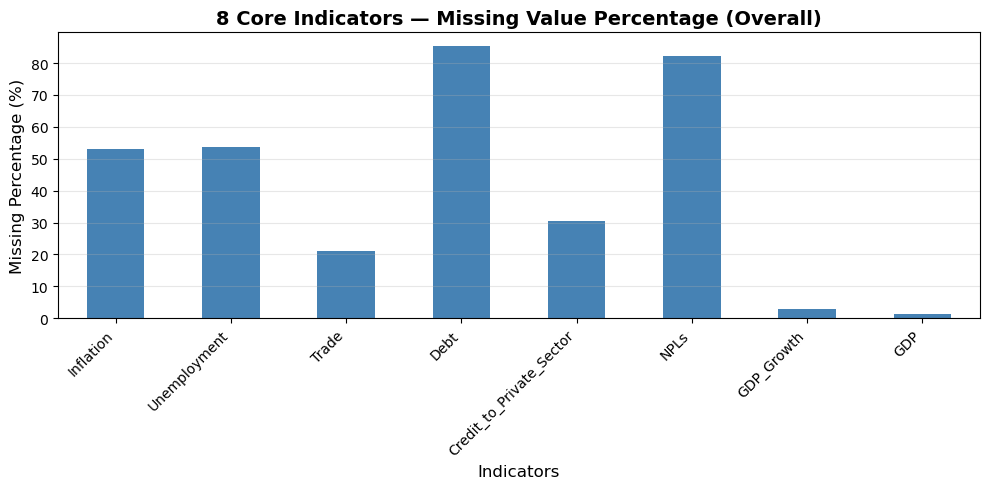

In [5]:
# Missing values for core indicators
core_indicators = ['Inflation','Unemployment','Trade','Debt','Credit_to_Private_Sector','NPLs','GDP_Growth','GDP']


print("Core indicators missing value statistics:")
missing_stats = pd.DataFrame({
    'Missing Count': df[core_indicators].isnull().sum(),
    'Missing Rate(%)': (df[core_indicators].isnull().sum() / len(df) * 100).round(2)
})
print(missing_stats)

# Visualize missing values
plt.figure(figsize=(10, 5))
missing_pct = df[core_indicators].isnull().sum() / len(df) * 100
missing_pct.plot(kind='bar', color='steelblue')
plt.title('8 Core Indicators — Missing Value Percentage (Overall)', fontsize=14, fontweight='bold')
plt.xlabel('Indicators', fontsize=12)
plt.ylabel('Missing Percentage (%)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [6]:
WINDOWS = {"2000_2009": (2000, 2009), "2010_2014": (2010, 2014), "2015_2019": (2015, 2019)}
for tag, (ys, ye) in WINDOWS.items():
    df_win = df[(df['Year'] >= ys) & (df['Year'] <= ye)].copy()
    print(f"\n==== Window {tag}: {ys}-{ye} ====")
    print(f"Rows: {len(df_win)} | Countries: {df_win['Country Name'].nunique()}")
    print("Data volume per year:"); print(df_win.groupby('Year').size())

    print("Core indicators missing value stats (this window):")
    ms = pd.DataFrame({
        'Missing Count': df_win[core_indicators].isnull().sum(),
        'Missing Rate(%)': (df_win[core_indicators].isnull().sum() / len(df_win) * 100).round(2)
    }).sort_values('Missing Rate(%)', ascending=False)
    print(ms)

    comp = []
    for country, g in df_win.groupby('Country Name'):
        total = g.shape[0] * len(core_indicators)
        non_null = g[core_indicators].notna().sum().sum()
        pct = (non_null / total * 100) if total else 0.0
        comp.append({'Country': country, 'Records': g.shape[0], 'Completeness(%)': round(pct, 2)})
    comp_df = pd.DataFrame(comp).sort_values('Completeness(%)', ascending=False)
    print("\nTop 20 completeness:"); print(comp_df.head(20))
    print("\nBottom 20 completeness:"); print(comp_df.tail(20))



==== Window 2000_2009: 2000-2009 ====
Rows: 2586 | Countries: 261
Data volume per year:
Year
2000    256
2001    256
2002    259
2003    259
2004    259
2005    259
2006    259
2007    259
2008    259
2009    261
dtype: int64
Core indicators missing value stats (this window):
                          Missing Count  Missing Rate(%)
NPLs                               2318            89.64
Debt                               2144            82.91
Inflation                          1373            53.09
Unemployment                       1115            43.12
Credit_to_Private_Sector            639            24.71
Trade                               442            17.09
GDP_Growth                           71             2.75
GDP                                  17             0.66

Top 20 completeness:
                Country  Records  Completeness(%)
13            Australia       10            93.75
230         Switzerland       10            93.75
37               Canada       10     

## 3. Data Preparation and Period Window Division

In [7]:
# Define periods
WINDOWS = {"2000_2009": (2000, 2009), "2010_2014": (2010, 2014), "2015_2019": (2015, 2019)}
core_indicators = [
    "Inflation","Unemployment","Trade","Debt",
    "Credit_to_Private_Sector","NPLs","GDP_Growth","GDP"
]

FOCUS_COUNTRIES = ["India", "China", "Germany", "Afghanistan"]

# Filter Pre and Post period data
df_win_raw = {tag: df[(df['Year'] >= ys) & (df['Year'] <= ye)].copy()
              for tag, (ys, ye) in WINDOWS.items()}


for tag, d in df_win_raw.items():
    print(f"{tag} raw data volume: {len(d)}")



2000_2009 raw data volume: 2586
2010_2014 raw data volume: 1307
2015_2019 raw data volume: 1302


In [8]:
def aggregate_period(df_period, period_name):
    """
    Aggregate mean for core indicators by country.
    """
    COUNTRY_COL = "Country Name"

    # ensure country column
    if COUNTRY_COL not in df_period.columns:
        if "index" in df_period.columns:
            df_period = df_period.rename(columns={"index": COUNTRY_COL})
        else:
            cname = next((c for c in df_period.columns if "country" in str(c).lower()), None)
            if cname:
                df_period = df_period.rename(columns={cname: COUNTRY_COL})
            else:
                raise KeyError("No country-like column found.")

    # use only available core indicators
    available = [c for c in core_indicators if c in df_period.columns]

    # aggregate
    df_agg = df_period.groupby(COUNTRY_COL)[available].mean().reset_index()

    # logs
    print(f"{period_name} aggregated rows: {len(df_agg)}")
    print(f"{period_name} missing after aggregation:")
    print(df_agg[available].isnull().sum())

    return df_agg



# Aggregate three windows and save
df_win = {tag: aggregate_period(d, tag) for tag, d in df_win_raw.items()}
for tag, d in df_win.items():
    d.to_csv(os.path.join("data", f"clean_{tag}.csv"), index=False)




2000_2009 aggregated rows: 261
2000_2009 missing after aggregation:
Inflation                    79
Unemployment                 37
Trade                        38
Debt                        190
Credit_to_Private_Sector     45
NPLs                        178
GDP_Growth                    3
GDP                           0
dtype: int64
2010_2014 aggregated rows: 262
2010_2014 missing after aggregation:
Inflation                    24
Unemployment                 46
Trade                        33
Debt                        194
Credit_to_Private_Sector     36
NPLs                        135
GDP_Growth                    3
GDP                           0
dtype: int64
2015_2019 aggregated rows: 261
2015_2019 missing after aggregation:
Inflation                    24
Unemployment                 52
Trade                        31
Debt                        193
Credit_to_Private_Sector     34
NPLs                        113
GDP_Growth                    2
GDP                           1
dt

In [9]:
def filter_quality_data(df, min_indicators=2):
    """
    Filter data quality: keep countries with at least min_indicators non-null core indicators
    Adjusted to 2 indicators to retain more data and avoid excessive deletion
    """
    import pandas as pd
    if isinstance(df, pd.Series):     
        df = df.to_frame().T               

    available = [c for c in core_indicators if c in df.columns]  
    valid_count = df[available].notna().sum(axis=1)             
    df_filtered = df[valid_count >= min_indicators].copy()
    return df_filtered

df_win_filtered = {tag: filter_quality_data(d, min_indicators=2) for tag, d in df_win.items()}

for tag in df_win.keys():
    print(f"{tag} filtered data volume: {len(df_win_filtered[tag])} (before: {len(df_win[tag])})")


2000_2009 filtered data volume: 259 (before: 261)
2010_2014 filtered data volume: 260 (before: 262)
2015_2019 filtered data volume: 260 (before: 261)


In [10]:
COUNTRY_COL = "Country Name"

# normalize country col if needed
for tag, d in df_win.items():
    if COUNTRY_COL not in d.columns:
        # try promote 'index' or detect a country-like column
        if "index" in d.columns:
            df_win[tag] = d.rename(columns={"index": COUNTRY_COL})
        else:
            cname = next((c for c in d.columns if "country" in str(c).lower()), None)
            if cname: df_win[tag] = d.rename(columns={cname: COUNTRY_COL})

# use filtered dict for quality, fall back to df_win if not present
base = df_win_filtered if 'df_win_filtered' in globals() else df_win

# strict intersection; fallback to appear in >=2 windows
common_countries = set.intersection(*(set(d[COUNTRY_COL]) for d in base.values()))
if len(common_countries) == 0:
    counts = {}
    for d in base.values():
        for c in set(d[COUNTRY_COL]): counts[c] = counts.get(c, 0) + 1
    common_countries = {c for c, k in counts.items() if k >= 2}
    print(f"[WARN] Using countries present in >=2 windows: {len(common_countries)}")
else:
    print(f"Number of countries present in ALL windows: {len(common_countries)}")

# keep only common countries (per window)
df_win_clean = {tag: d[d[COUNTRY_COL].isin(common_countries)].copy() for tag, d in base.items()}
DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

# save per window
for tag, d in df_win_clean.items():
    d.to_csv(os.path.join(DATA_DIR, f"clean_{tag}.csv"), index=False, encoding="utf-8-sig")
    print(f"Saved data/clean_{tag}.csv  rows={len(d)}")


Number of countries present in ALL windows: 257
Saved data/clean_2000_2009.csv  rows=257
Saved data/clean_2010_2014.csv  rows=257
Saved data/clean_2015_2019.csv  rows=257


In [11]:

# Save cleaned data

for tag, d in df_win_clean.items():
    d.to_csv(f"data/clean_{tag}.csv", index=False, encoding="utf-8-sig")


print("Cleaned data saved to:")
for tag in df_win_clean.keys():
    print(f"  - data/clean_{tag}.csv")


# Display first few rows of cleaned data
for tag, d in df_win_clean.items():
    print(f"\n{tag} data preview:")
    print(d.head())



Cleaned data saved to:
  - data/clean_2000_2009.csv
  - data/clean_2010_2014.csv
  - data/clean_2015_2019.csv

2000_2009 data preview:
                  Country Name  Inflation  Unemployment      Trade  Debt  \
0                  Afghanistan   8.768168        2.4940        NaN   NaN   
1  Africa Eastern and Southern  10.688196           NaN  59.462507   NaN   
2   Africa Western and Central   6.079038           NaN        NaN   NaN   
3                      Albania   2.793896       13.0281  69.150933   NaN   
4                      Algeria   4.146536       18.7160  62.871920   NaN   

   Credit_to_Private_Sector       NPLs  GDP_Growth           GDP  
0                  7.913824        NaN    9.460375  6.535489e+09  
1                 79.571961        NaN    4.370458  4.805909e+11  
2                 10.486776        NaN    6.188195  3.219802e+11  
3                 37.310937        NaN    5.880222  7.948517e+09  
4                 10.748607  21.141551    3.830000  1.044431e+11  

2010_

In [12]:
for tag, d in df_win_clean.items():
    print(f"\n{tag} data preview:")
    print(d.head())




2000_2009 data preview:
                  Country Name  Inflation  Unemployment      Trade  Debt  \
0                  Afghanistan   8.768168        2.4940        NaN   NaN   
1  Africa Eastern and Southern  10.688196           NaN  59.462507   NaN   
2   Africa Western and Central   6.079038           NaN        NaN   NaN   
3                      Albania   2.793896       13.0281  69.150933   NaN   
4                      Algeria   4.146536       18.7160  62.871920   NaN   

   Credit_to_Private_Sector       NPLs  GDP_Growth           GDP  
0                  7.913824        NaN    9.460375  6.535489e+09  
1                 79.571961        NaN    4.370458  4.805909e+11  
2                 10.486776        NaN    6.188195  3.219802e+11  
3                 37.310937        NaN    5.880222  7.948517e+09  
4                 10.748607  21.141551    3.830000  1.044431e+11  

2010_2014 data preview:
                  Country Name  Inflation  Unemployment      Trade       Debt  \
0         

In [13]:
# Impute missing values (using median for each indicator)
def impute_only(df, period_name):
    df_work = df.copy()
    print(f"\n{period_name} missing before impute:")
    print(df_work[core_indicators].isnull().sum())
    for indicator in core_indicators:
        if indicator in df_work.columns:
            median_val = df_work[indicator].median()
            df_work[indicator] = df_work[indicator].fillna(median_val)
    return df_work


# impute per window
df_imputed = {tag: impute_only(d, tag) for tag, d in df_win_clean.items()}

# global standardization (fit on concatenated data)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
concat_vals = pd.concat([df_imputed[tag][core_indicators] for tag in df_imputed], axis=0)
scaler.fit(concat_vals.values)

df_std = {}
for tag, d in df_imputed.items():
    d_std = d.copy()
    d_std[core_indicators] = scaler.transform(d[core_indicators].values)
    df_std[tag] = d_std
    print(f"{tag} standardized. shape={d_std.shape}")




2000_2009 missing before impute:
Inflation                    75
Unemployment                 34
Trade                        35
Debt                        186
Credit_to_Private_Sector     42
NPLs                        174
GDP_Growth                    1
GDP                           0
dtype: int64

2010_2014 missing before impute:
Inflation                    20
Unemployment                 41
Trade                        29
Debt                        189
Credit_to_Private_Sector     32
NPLs                        130
GDP_Growth                    1
GDP                           0
dtype: int64

2015_2019 missing before impute:
Inflation                    21
Unemployment                 48
Trade                        27
Debt                        189
Credit_to_Private_Sector     30
NPLs                        110
GDP_Growth                    1
GDP                           1
dtype: int64
2000_2009 standardized. shape=(257, 9)
2010_2014 standardized. shape=(257, 9)
2015_2019 sta

## 5. K-Means Clustering Analysis (k=3)

Perform K-Means clustering for Pre and Post periods separately


In [14]:
# K-Means clustering
def perform_kmeans_clustering(df_std_win: dict, df_imputed_win: dict, indicators, k=3, seed=42, var_threshold=0.80):
    """
    Run PCA(>=var_threshold cumulative variance) + KMeans(k) for each window.
    Inputs:
        df_std_win:   {window_tag: DataFrame with standardized indicators + 'Country Name'}
        df_imputed_win: {window_tag: DataFrame with original-scale (imputed) indicators + 'Country Name'}
        indicators:   list of indicator column names
    Returns:
        labels_dict:  {window_tag: DataFrame['Country Name','cluster']}
        gmeans_std:   {window_tag: DataFrame cluster x indicators (standardized)}
        gmeans_orig:  {window_tag: DataFrame cluster x indicators (original scale)}
        metrics:      {window_tag: dict(silhouette, calinski_harabasz, davies_bouldin, n_components)}
    """
    from sklearn.decomposition import PCA
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

    labels_dict, gmeans_std, gmeans_orig, metrics = {}, {}, {}, {}

    for tag, df_std in df_std_win.items():
        X = df_std[indicators].values

        # PCA (choose n_components by cumulative variance >= var_threshold)
        pca = PCA(n_components=None, random_state=seed)
        Xp = pca.fit_transform(X)
        cum = pca.explained_variance_ratio_.cumsum()
        n = int(np.searchsorted(cum, var_threshold) + 1)
        Xp = Xp[:, :n]

        # KMeans on PCA space
        km = KMeans(n_clusters=k, random_state=seed, n_init=10)
        labels = km.fit_predict(Xp)

        # labels df
        lab_df = df_std[["Country Name"]].copy()
        lab_df["cluster"] = labels
        labels_dict[tag] = lab_df

        # group means (standardized)
        tmp_std = df_std.copy()
        tmp_std["cluster"] = labels
        gmeans_std[tag] = tmp_std.groupby("cluster")[indicators].mean()

        # group means (original scale)
        dfo = df_imputed_win[tag].copy()
        dfo["cluster"] = labels
        gmeans_orig[tag] = dfo.groupby("cluster")[indicators].mean()

        # clustering metrics
        metrics[tag] = dict(
            silhouette=float(silhouette_score(Xp, labels)),
            calinski_harabasz=float(calinski_harabasz_score(Xp, labels)),
            davies_bouldin=float(davies_bouldin_score(Xp, labels)),
            n_components=int(n)
        )

        # brief log
        print(f"\n[{tag}] samples per cluster:")
        print(lab_df["cluster"].value_counts().sort_index())
        print(f"[{tag}] PCA components: {n}, cum.var={cum[n-1]:.3f}")

    return labels_dict, gmeans_std, gmeans_orig, metrics


# Ensure output dir
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Run clustering for all windows
labels_dict, gmeans_std_dict, gmeans_orig_dict, metrics_dict = perform_kmeans_clustering(
    df_std_win=df_std,                 # {tag: standardized df}
    df_imputed_win=df_imputed,         # {tag: imputed original-scale df}
    indicators=core_indicators,
    k=3,
    seed=42,
    var_threshold=0.80
)

# Save labels and group means per window
for tag in labels_dict:
    labels_path = os.path.join(RESULTS_DIR, f"labels_{tag}.csv")
    gmean_std_path = os.path.join(RESULTS_DIR, f"group_means_{tag}.csv")
    labels_dict[tag].to_csv(labels_path, index=False, encoding="utf-8-sig")
    gmeans_std_dict[tag].to_csv(gmean_std_path, encoding="utf-8-sig")
    print(f"Saved {labels_path}")
    print(f"Saved {gmean_std_path}")

# Save metrics summary
metrics_df = pd.DataFrame.from_dict(metrics_dict, orient="index")
metrics_df.index.name = "window"
metrics_df.reset_index().to_csv(os.path.join(RESULTS_DIR, "metrics.csv"), index=False, encoding="utf-8-sig")
print("Saved results/metrics.csv")

RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)




[2000_2009] samples per cluster:
cluster
0    172
1     59
2     26
Name: count, dtype: int64
[2000_2009] PCA components: 5, cum.var=0.862

[2010_2014] samples per cluster:
cluster
0     98
1    140
2     19
Name: count, dtype: int64
[2010_2014] PCA components: 5, cum.var=0.822

[2015_2019] samples per cluster:
cluster
0    239
1      2
2     16
Name: count, dtype: int64
[2015_2019] PCA components: 5, cum.var=0.807
Saved results/labels_2000_2009.csv
Saved results/group_means_2000_2009.csv
Saved results/labels_2010_2014.csv
Saved results/group_means_2010_2014.csv
Saved results/labels_2015_2019.csv
Saved results/group_means_2015_2019.csv
Saved results/metrics.csv


## 6. Cluster Migration Statistics


In [15]:
# === Cluster migration (three windows) & changepoint detection ===
import os
import json
import pandas as pd
import numpy as np

# ensure output dir variables
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# 1) Build migration edges for two transitions:
#    2000_2009 -> 2010_2014, and 2010_2014 -> 2015_2019
def load_labels(path, country_col="Country Name", label_col="cluster"):
    df = pd.read_csv(path)
    # allow either 'cluster' or 'Cluster' from upstream
    if label_col not in df.columns and "Cluster" in df.columns:
        df = df.rename(columns={"Cluster": label_col})
    # keep only necessary columns
    keep = [c for c in [country_col, label_col] if c in df.columns]
    return df[keep].copy()

def make_migration(labels_a, labels_b, country_col="Country Name", label_col="cluster",
                   a_name="A", b_name="B"):
    merged = labels_a.merge(labels_b, on=country_col, how="inner", suffixes=(f"_{a_name}", f"_{b_name}"))
    counts = (merged.groupby([f"{label_col}_{a_name}", f"{label_col}_{b_name}"])
                    .size().reset_index(name="count"))
    counts.columns = ["pre_group", "post_group", "count"]
    return merged, counts

# paths produced earlier by your clustering step:
lab_00 = os.path.join(RESULTS_DIR, "labels_2000_2009.csv")
lab_10 = os.path.join(RESULTS_DIR, "labels_2010_2014.csv")
lab_15 = os.path.join(RESULTS_DIR, "labels_2015_2019.csv")

labels_00 = load_labels(lab_00)
labels_10 = load_labels(lab_10)
labels_15 = load_labels(lab_15)

# transition 1: 00-09 -> 10-14
mig_1_df, mig_1_counts = make_migration(labels_00, labels_10, a_name="pre", b_name="post")
print(f"[00-09 -> 10-14] countries: {len(mig_1_df)}")
print(mig_1_counts)

mig_1_out = os.path.join(RESULTS_DIR, "migration_edges_2000_2009_to_2010_2014.csv")
mig_1_counts.to_csv(mig_1_out, index=False, encoding="utf-8-sig")
print(f"Saved {mig_1_out}")

# transition 2: 10-14 -> 15-19
mig_2_df, mig_2_counts = make_migration(labels_10, labels_15, a_name="pre", b_name="post")
print(f"[10-14 -> 15-19] countries: {len(mig_2_df)}")
print(mig_2_counts)

mig_2_out = os.path.join(RESULTS_DIR, "migration_edges_2010_2014_to_2015_2019.csv")
mig_2_counts.to_csv(mig_2_out, index=False, encoding="utf-8-sig")
print(f"Saved {mig_2_out}")

# (optional) show migration matrices
print("\nMigration matrix 00-09 -> 10-14:")
print(pd.crosstab(mig_1_df["cluster_pre"], mig_1_df["cluster_post"], margins=True, margins_name="Total"))
print("\nMigration matrix 10-14 -> 15-19:")
print(pd.crosstab(mig_2_df["cluster_pre"], mig_2_df["cluster_post"], margins=True, margins_name="Total"))

# 2) Changepoint detection on yearly global means
changepoint_indicators = [c for c in ["Inflation", "Unemployment", "GDP_Growth"] if c in df.columns]

df_yearly = (df.groupby("Year")[changepoint_indicators]
               .mean()
               .reset_index()
               .sort_values("Year"))

print("\nYearly data preview:")
print(df_yearly.head())
print(f"Data year range: {df_yearly['Year'].min()} - {df_yearly['Year'].max()}")
print(f"Number of data points: {len(df_yearly)}")

def detect_changepoints_simple(series: pd.Series, threshold_percentile=80, window=3):
    """
    Simple changepoint via absolute first-difference percentile.
    """
    vals = series.astype(float)
    diffs = vals.diff().abs()
    thresh = diffs.quantile(threshold_percentile / 100.0)
    idx = diffs[diffs > thresh].index.tolist()
    return idx

changepoints_dict = {}
for indicator in changepoint_indicators:
    s = df_yearly[indicator].dropna()
    years = df_yearly.loc[s.index, "Year"]
    if len(s) > 5:
        cp_idx = detect_changepoints_simple(s, threshold_percentile=80, window=3)
        cp_years = years.iloc[cp_idx].tolist()
        changepoints_dict[indicator] = cp_years
        print(f"{indicator} changepoints: {cp_years}")
    else:
        changepoints_dict[indicator] = []
        print(f"{indicator} insufficient data for changepoint detection.")

cp_out = os.path.join(RESULTS_DIR, "changepoints.json")
with open(cp_out, "w", encoding="utf-8") as f:
    json.dump(changepoints_dict, f, indent=2, ensure_ascii=True)
# === Country-level changepoints for 4 focus countries ===
indicators_for_cp = [c for c in ["Inflation","Unemployment","GDP_Growth"] if c in df.columns]

def _country_yearly(df_all, country, indicators):
    d = (df_all[df_all["Country Name"] == country]
         .groupby("Year")[indicators].mean()
         .reset_index().sort_values("Year"))
    return d

def _cp_simple(series, percentile=80):
    diffs = series.astype(float).diff().abs()
    thresh = diffs.quantile(percentile/100.0)
    return diffs[diffs > thresh].index.tolist()

country_cps = {}  # {country: {indicator: [years,...]}}
for c in FOCUS_COUNTRIES:
    dcy = _country_yearly(df, c, indicators_for_cp)
    cd = {}
    for ind in indicators_for_cp:
        s = dcy[ind].dropna()
        cd[ind] = dcy.loc[_cp_simple(s, 80), "Year"].tolist() if len(s) > 5 else []
    country_cps[c] = cd

print(f"\nSaved {cp_out}")


[00-09 -> 10-14] countries: 257
   pre_group  post_group  count
0          0           0     40
1          0           1    123
2          0           2      9
3          1           0     43
4          1           1      6
5          1           2     10
6          2           0     15
7          2           1     11
Saved results/migration_edges_2000_2009_to_2010_2014.csv
[10-14 -> 15-19] countries: 257
   pre_group  post_group  count
0          0           0     88
1          0           1      1
2          0           2      9
3          1           0    132
4          1           1      1
5          1           2      7
6          2           0     19
Saved results/migration_edges_2010_2014_to_2015_2019.csv

Migration matrix 00-09 -> 10-14:
cluster_post   0    1   2  Total
cluster_pre                     
0             40  123   9    172
1             43    6  10     59
2             15   11   0     26
Total         98  140  19    257

Migration matrix 10-14 -> 15-19:
cluster_post

Saved: /Users/ethan/5048/Untitled Folder/fig/changepoint_India.png


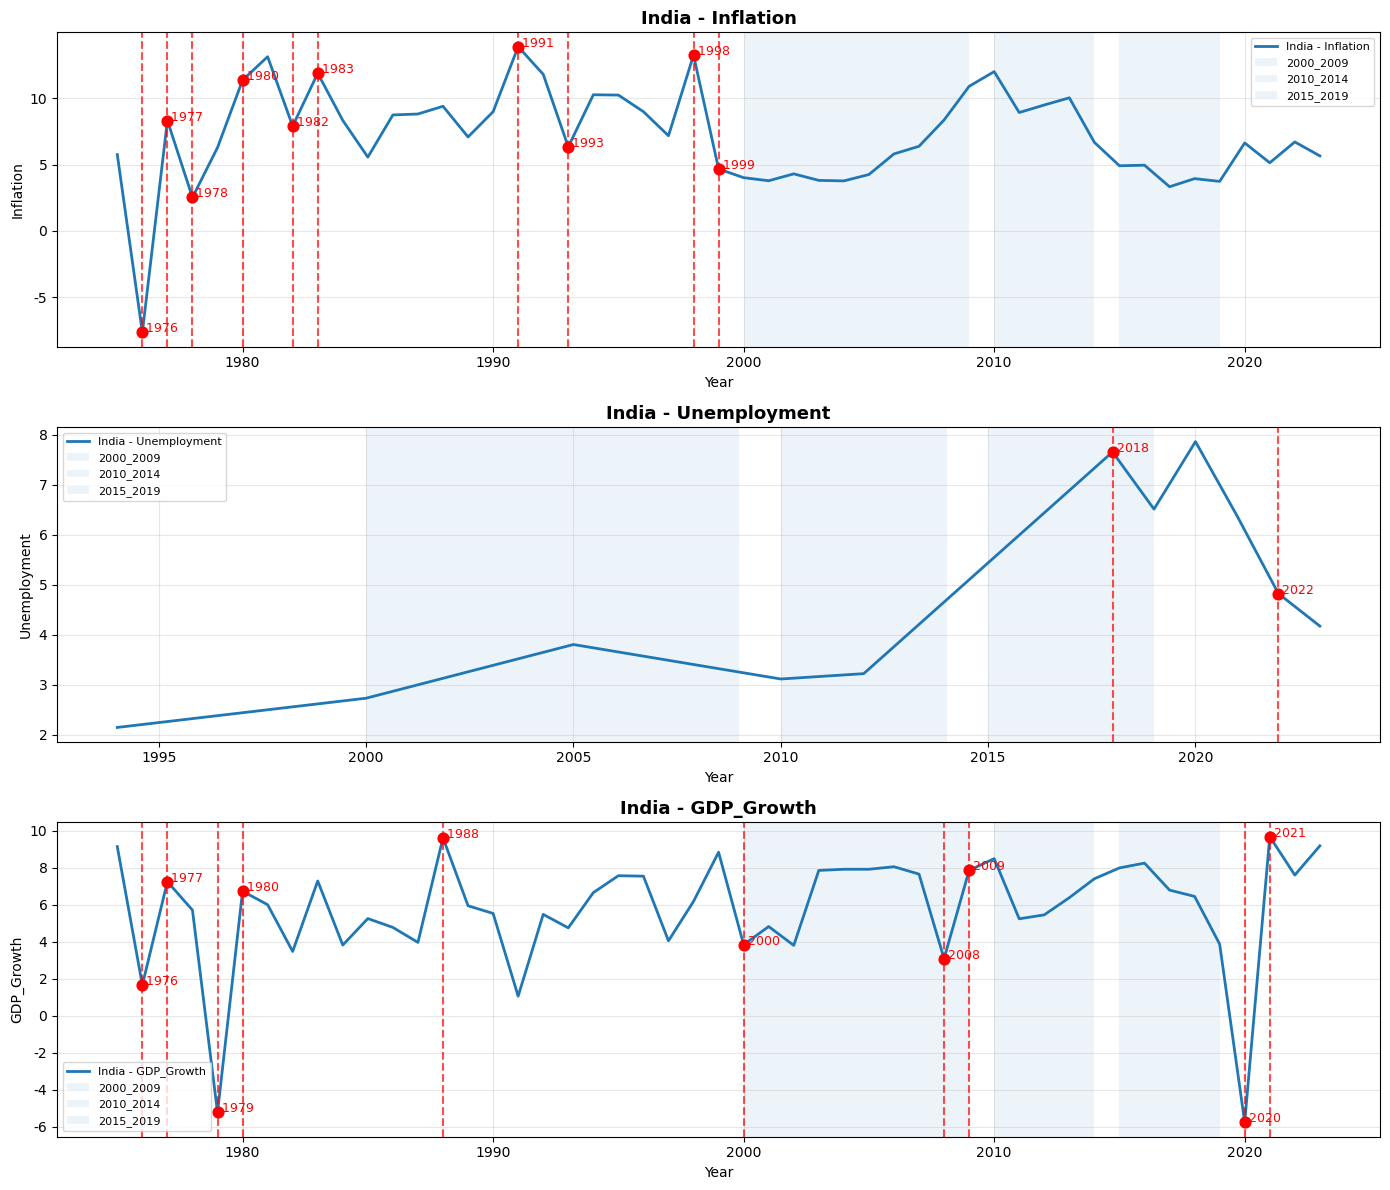

Saved: /Users/ethan/5048/Untitled Folder/fig/changepoint_China.png


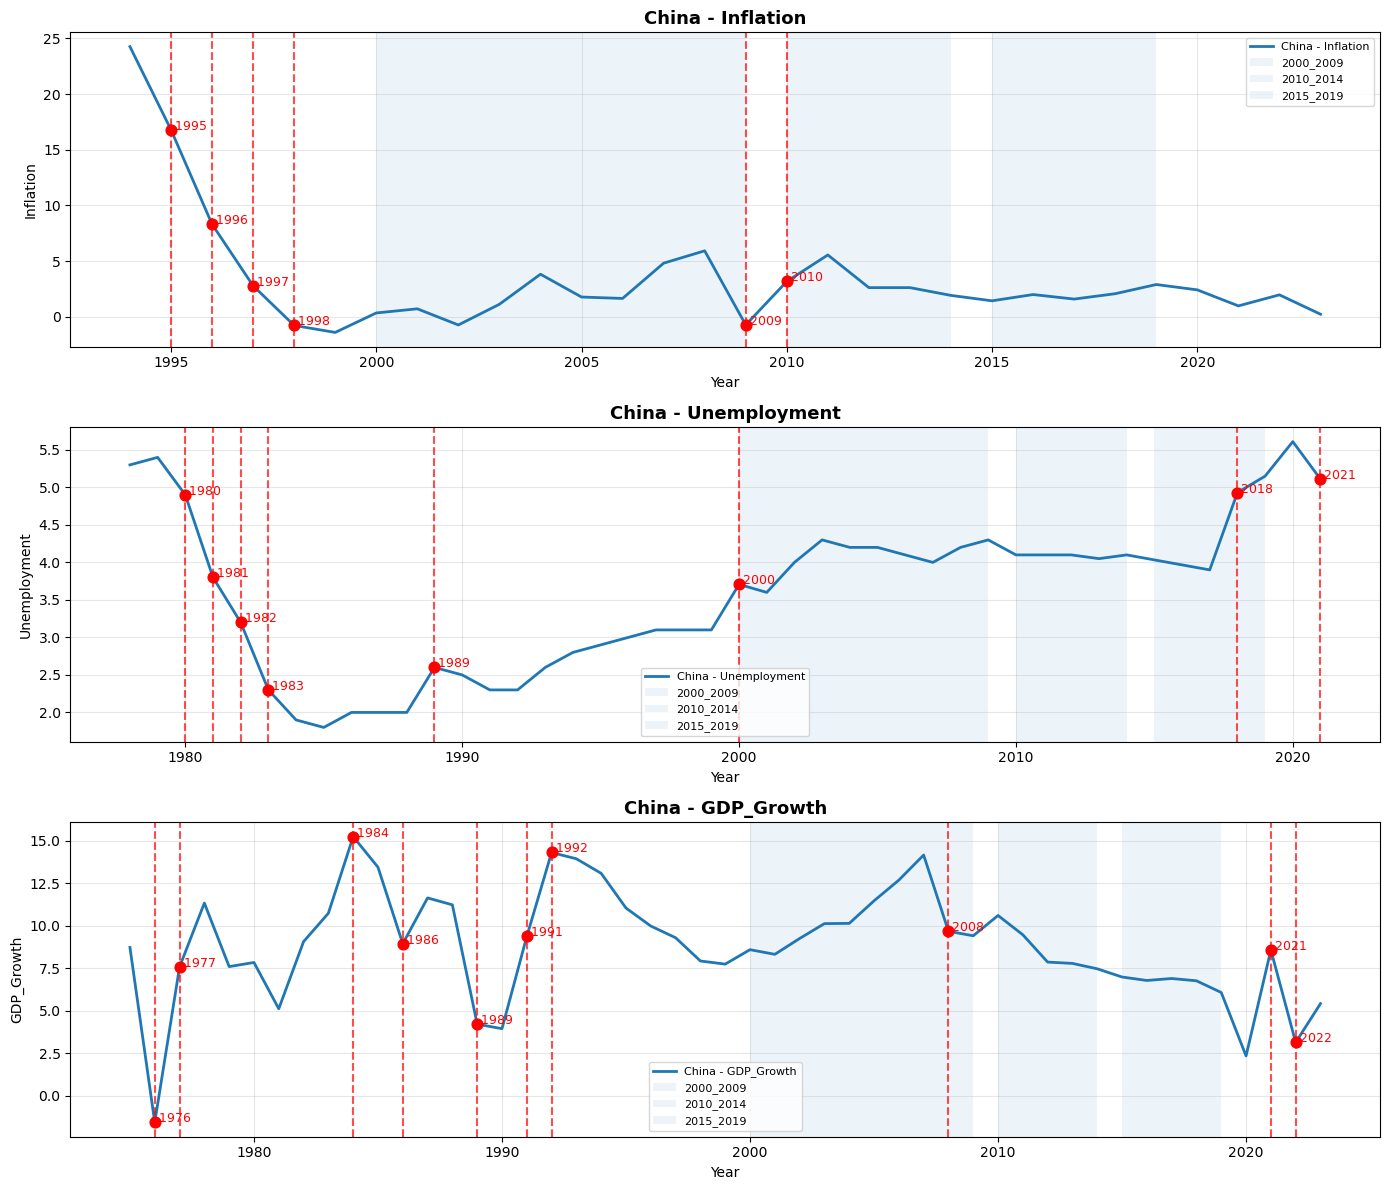

Saved: /Users/ethan/5048/Untitled Folder/fig/changepoint_Germany.png


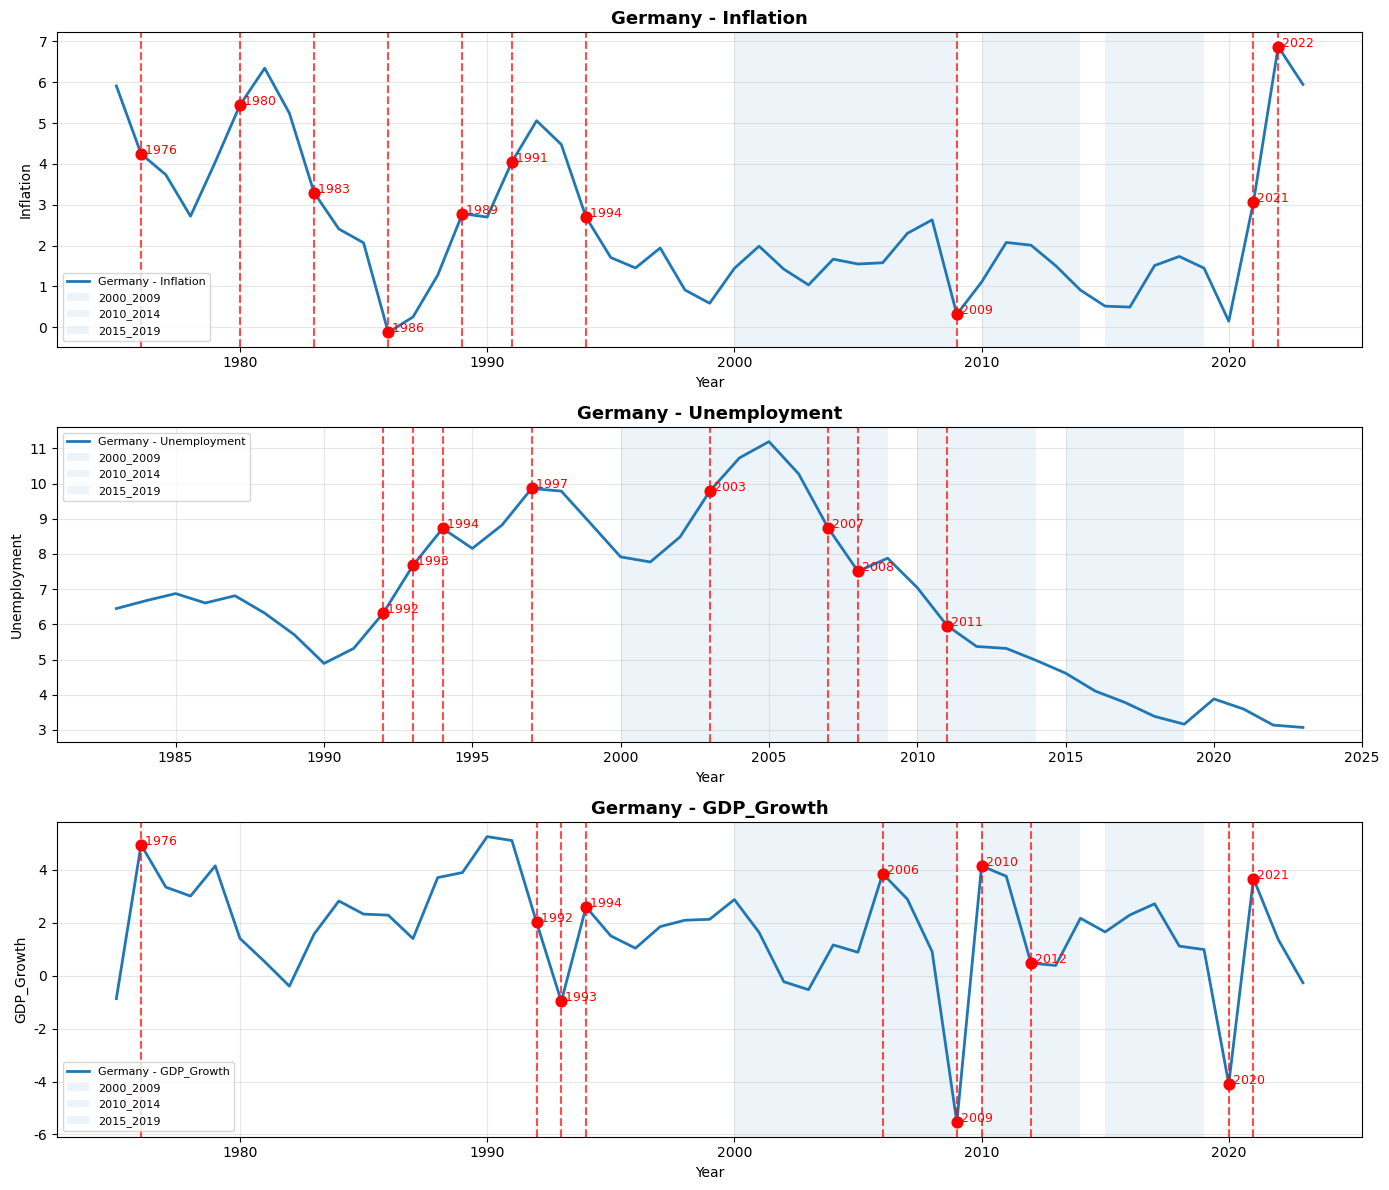

Saved: /Users/ethan/5048/Untitled Folder/fig/changepoint_Afghanistan.png


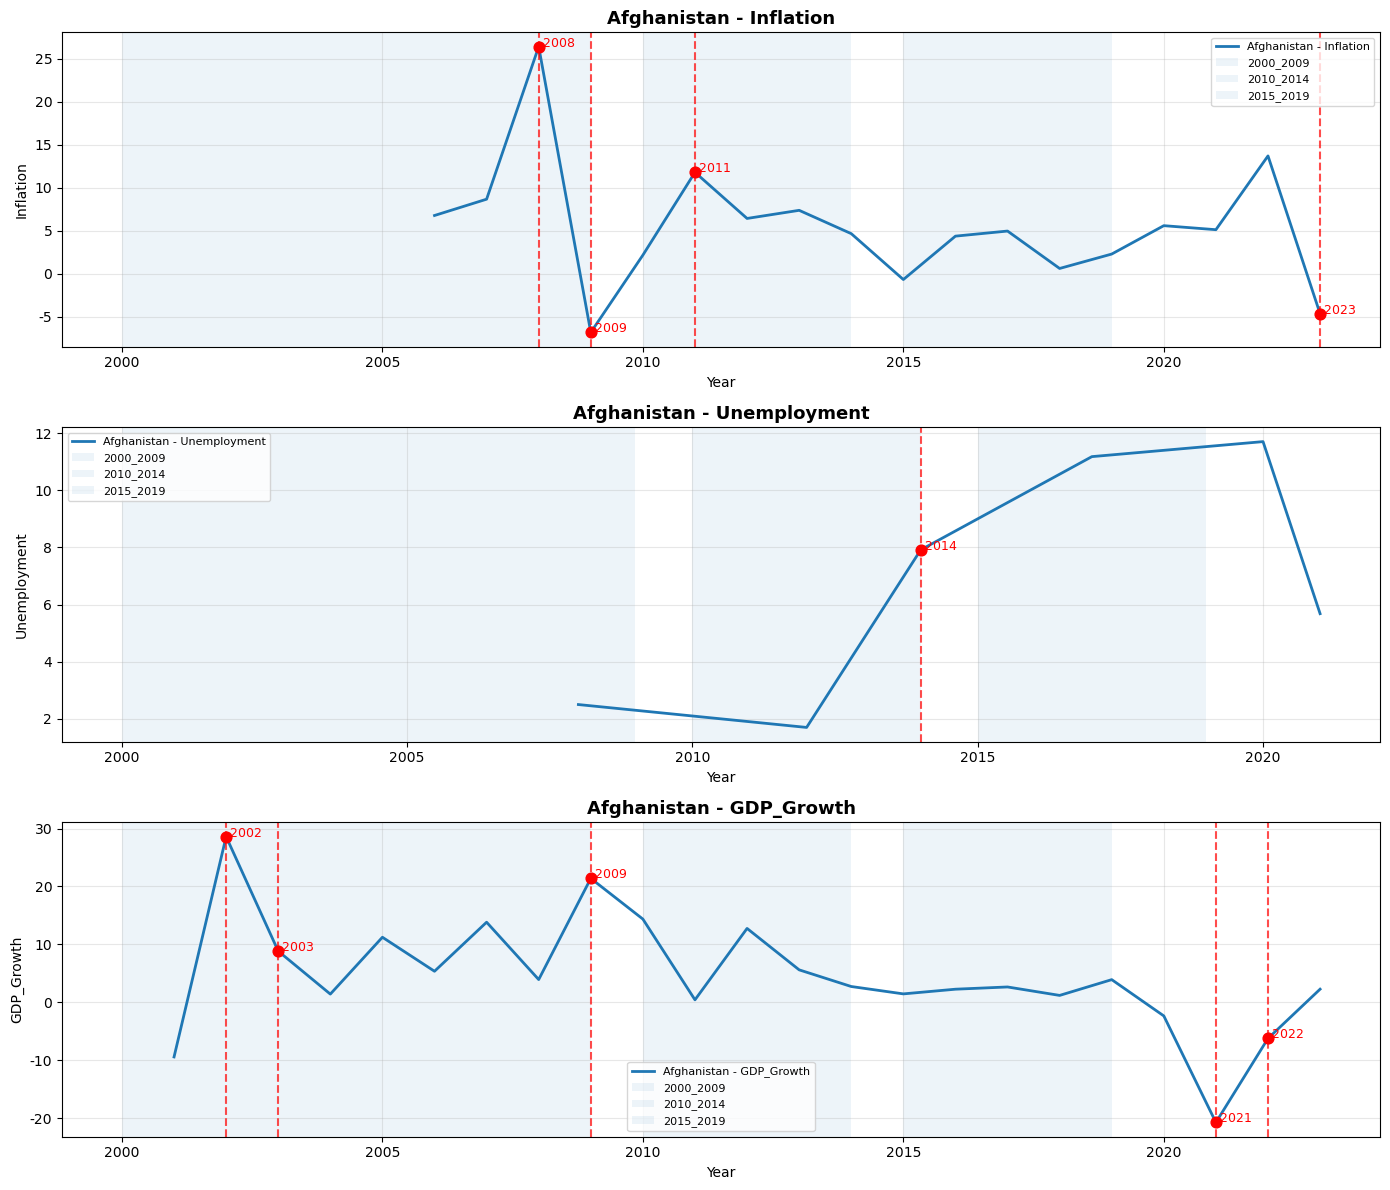

In [16]:
# === Plot per-country lines with WINDOWS shading & changepoints ===
import os
import matplotlib.pyplot as plt

def plot_country_changepoints(df_all, country, indicators, cps_dict, filename):
    d = (df_all[df_all["Country Name"] == country]
         .groupby("Year")[indicators].mean()
         .reset_index().sort_values("Year"))

    fig, axes = plt.subplots(len(indicators), 1, figsize=(14, 4*len(indicators)))
    if len(indicators) == 1:
        axes = [axes]

    for i, ind in enumerate(indicators):
        ax = axes[i]
        dd = d[["Year", ind]].dropna()
        ax.plot(dd["Year"], dd[ind], linewidth=2, label=f"{country} - {ind}")

        # shade WINDOWS
        for tag, (ys, ye) in WINDOWS.items():
            ax.axvspan(ys, ye, alpha=0.08, label=tag)

        # changepoints
        for y in cps_dict.get(country, {}).get(ind, []):
            if y in dd["Year"].values:
                val = float(dd.loc[dd["Year"] == y, ind].iloc[0])
                ax.axvline(y, color="red", linestyle="--", alpha=0.7)
                ax.scatter([y], [val], color="red", s=60, zorder=3)
                ax.text(y, val, f" {int(y)}", color="red", fontsize=9)

        # de-duplicate legend
        handles, labels = ax.get_legend_handles_labels()
        uniq = dict(zip(labels, handles))
        ax.legend(uniq.values(), uniq.keys(), loc="best", fontsize=8)

        ax.set_title(f"{country} - {ind}", fontsize=13, fontweight="bold")
        ax.set_xlabel("Year"); ax.set_ylabel(ind); ax.grid(True, alpha=0.3)

    os.makedirs(os.path.dirname(filename) or ".", exist_ok=True)
    plt.tight_layout(); plt.savefig(filename, dpi=300, bbox_inches="tight")
    print("Saved:", os.path.abspath(filename)); plt.show()

os.makedirs("fig", exist_ok=True)
for c in FOCUS_COUNTRIES:
    out = f"fig/changepoint_{c.replace(' ','_')}.png"
    plot_country_changepoints(df, c, indicators_for_cp, country_cps, out)


## 8. Statistical Testing (Pre vs Post)




In [17]:
# === Statistical testing: pairwise comparisons between windows ===
import os
from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np
import pandas as pd

RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

pairs = [("2000_2009", "2010_2014"), ("2010_2014", "2015_2019")]
stats_rows = []

def _align_by_country(a_df, b_df, cols, country_col="Country Name"):
    a_keep = [country_col] + [c for c in cols if c in a_df.columns]
    b_keep = [country_col] + [c for c in cols if c in b_df.columns]
    a = a_df[a_keep].copy()
    b = b_df[b_keep].copy()
    ab = a.merge(b, on=country_col, how="inner", suffixes=("_a", "_b"))
    return ab

for a, b in pairs:
    if a not in df_imputed or b not in df_imputed:
        print(f"[WARN] Missing window in df_imputed: {a} or {b}")
        continue

    aligned = _align_by_country(df_imputed[a], df_imputed[b], core_indicators, country_col="Country Name")

    for ind in core_indicators:
        col_a = f"{ind}_a"
        col_b = f"{ind}_b"
        if col_a not in aligned.columns or col_b not in aligned.columns:
            continue

        pre_vals = aligned[col_a].astype(float).to_numpy()
        post_vals = aligned[col_b].astype(float).to_numpy()

        # drop NaNs
        pre = pre_vals[~np.isnan(pre_vals)]
        post = post_vals[~np.isnan(post_vals)]

        if len(pre) < 3 or len(post) < 3:
            stats_rows.append({
                "comparison": f"{a} vs {b}",
                "indicator": ind,
                "n_pre": len(pre),
                "n_post": len(post),
                "mean_pre": np.nanmean(pre) if len(pre) else np.nan,
                "mean_post": np.nanmean(post) if len(post) else np.nan,
                "diff_post_minus_pre": np.nan,
                "t_stat": np.nan,
                "t_pvalue": np.nan,
                "u_stat": np.nan,
                "u_pvalue": np.nan,
                "cohens_d": np.nan,
                "signif_t(p<0.05)": "NA",
                "signif_u(p<0.05)": "NA"
            })
            continue

        # t-test (Welch not enabled here; keep same as your original)
        t_stat, t_p = ttest_ind(pre, post, nan_policy="omit")

        # Mann-Whitney U
        try:
            u_stat, u_p = mannwhitneyu(pre, post, alternative="two-sided")
        except ValueError:
            u_stat, u_p = np.nan, np.nan  # identical distributions or invalid input

        # Cohen's d (pooled SD with ddof=1)
        s1 = np.nanvar(pre, ddof=1)
        s2 = np.nanvar(post, ddof=1)
        s_pool = np.sqrt((s1 + s2) / 2.0) if np.isfinite(s1) and np.isfinite(s2) else np.nan
        d = (np.nanmean(post) - np.nanmean(pre)) / s_pool if (s_pool is not None and s_pool > 0) else np.nan

        stats_rows.append({
            "comparison": f"{a} vs {b}",
            "indicator": ind,
            "n_pre": int(len(pre)),
            "n_post": int(len(post)),
            "mean_pre": float(np.nanmean(pre)),
            "mean_post": float(np.nanmean(post)),
            "diff_post_minus_pre": float(np.nanmean(post) - np.nanmean(pre)),
            "t_stat": float(t_stat) if np.isfinite(t_stat) else np.nan,
            "t_pvalue": float(t_p) if np.isfinite(t_p) else np.nan,
            "u_stat": float(u_stat) if np.isfinite(u_stat) else np.nan,
            "u_pvalue": float(u_p) if np.isfinite(u_p) else np.nan,
            "cohens_d": float(d) if np.isfinite(d) else np.nan,
            "signif_t(p<0.05)": "Yes" if (np.isfinite(t_p) and t_p < 0.05) else "No",
            "signif_u(p<0.05)": "Yes" if (np.isfinite(u_p) and u_p < 0.05) else "No"
        })

stats_summary = pd.DataFrame(stats_rows)
print("\nStatistical testing results (pairwise windows):")
print(stats_summary.to_string(index=False))

stats_summary.to_csv(os.path.join(RESULTS_DIR, "stats_summary.csv"), index=False, encoding="utf-8-sig")
print("Saved results/stats_summary.csv")



Statistical testing results (pairwise windows):
            comparison                indicator  n_pre  n_post     mean_pre    mean_post  diff_post_minus_pre    t_stat     t_pvalue  u_stat     u_pvalue  cohens_d signif_t(p<0.05) signif_u(p<0.05)
2000_2009 vs 2010_2014                Inflation    257     257 5.853210e+00 4.687327e+00        -1.165883e+00  3.035504 2.523535e-03 42924.0 3.887288e-09 -0.267781              Yes              Yes
2000_2009 vs 2010_2014             Unemployment    257     257 8.131426e+00 7.839552e+00        -2.918738e-01  0.585027 5.587872e-01 34955.5 2.513390e-01 -0.051609               No               No
2000_2009 vs 2010_2014                    Trade    257     257 8.309827e+01 8.771099e+01         4.612721e+00 -1.031581 3.027554e-01 30354.0 1.126818e-01  0.091002               No               No
2000_2009 vs 2010_2014                     Debt    257     257 4.602707e+01 4.298202e+01        -3.045053e+00  2.209528 2.757974e-02 51640.0 2.556832e-31 -0.19

## 9. Visualization

### 9.1 Parallel Coordinates Plot


Parallel coordinates plot saved: fig/pcp_2000_2009.png


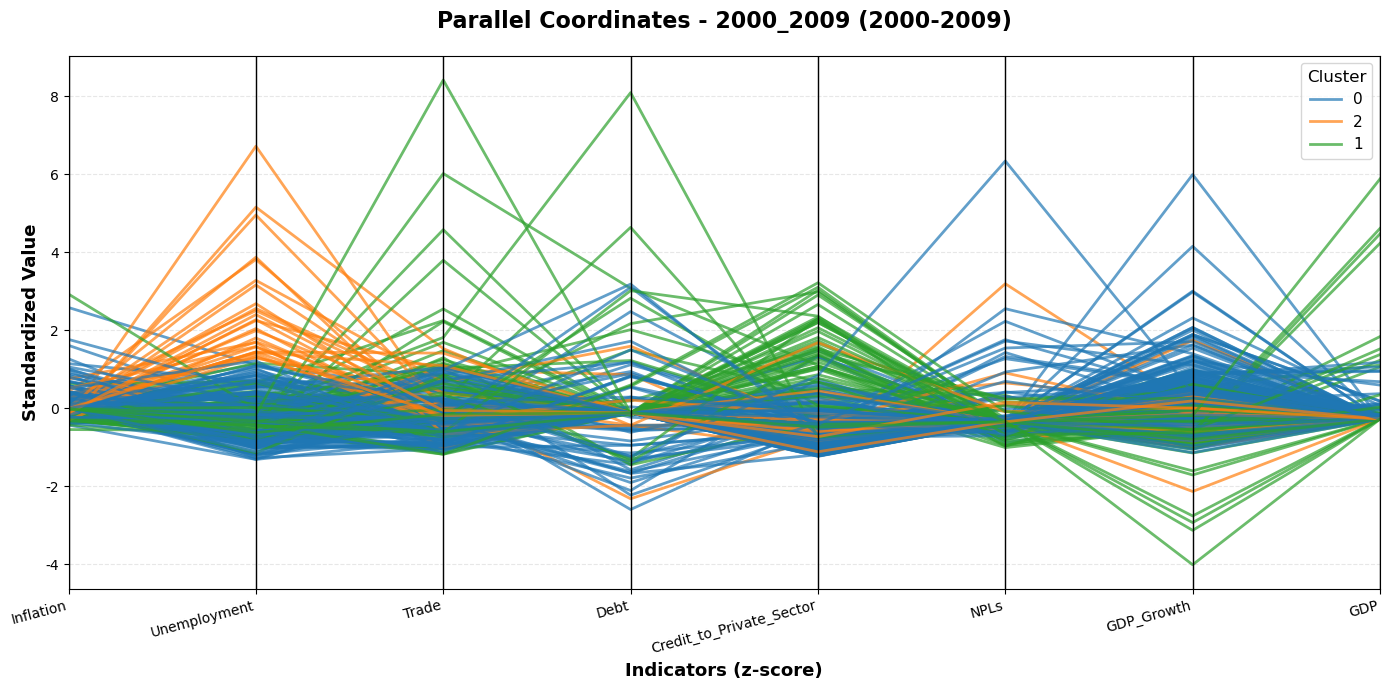

Parallel coordinates plot saved: fig/pcp_2010_2014.png


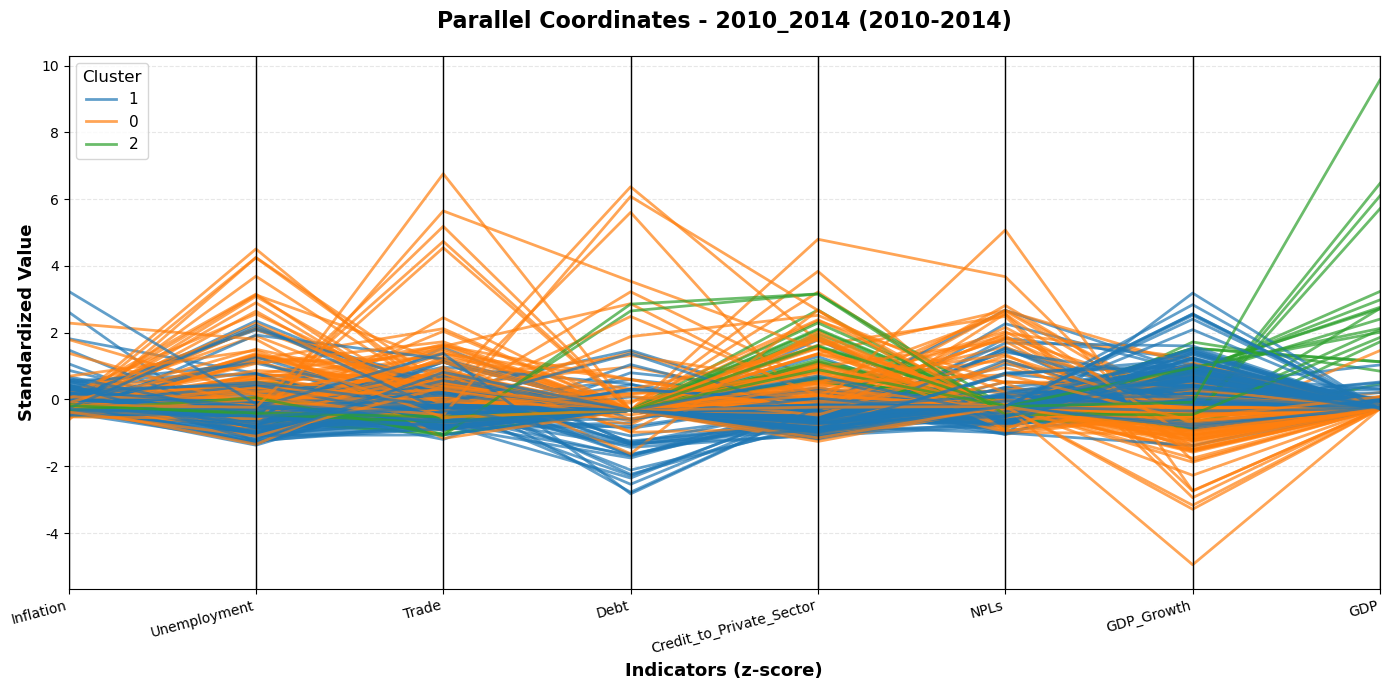

Parallel coordinates plot saved: fig/pcp_2015_2019.png


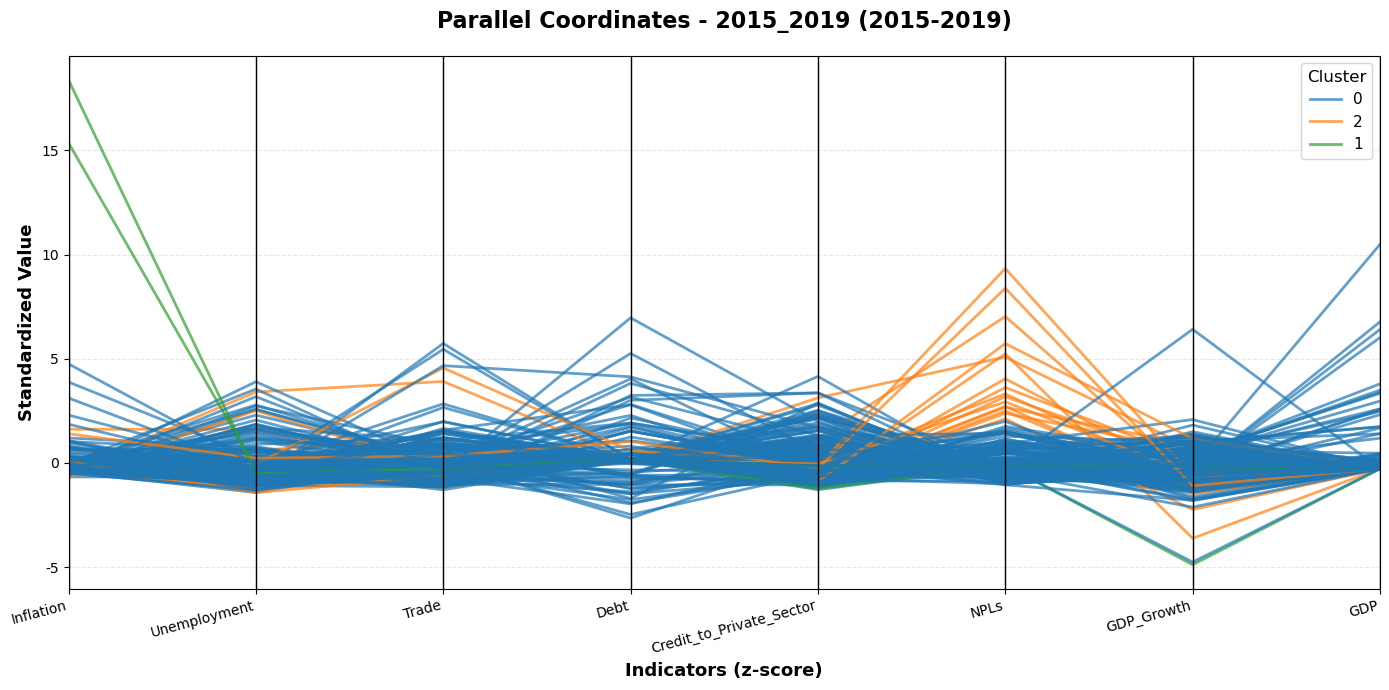

In [18]:
from pandas.plotting import parallel_coordinates
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_parallel_coordinates_window(df_std, labels, window_tag, filename, indicators=None):
    """
    Plot parallel coordinates for one window.
    df_std:      DataFrame (standardized), must contain indicators.
    labels:      1D array-like of cluster labels aligned with df_std rows.
    window_tag:  key in WINDOWS, e.g., "2000_2009"
    filename:    output path (png)
    indicators:  list of columns to plot; defaults to core_indicators
    """
    if indicators is None:
        indicators = core_indicators

    # prepare data
    plot_data = df_std[indicators].copy()
    plot_data["Cluster"] = np.asarray(labels).astype(str)

    # colors (auto based on number of clusters)
    uniq = np.unique(plot_data["Cluster"])
    n = len(uniq)
    base = list(plt.cm.tab10.colors) + list(plt.cm.tab20.colors)
    if n > len(base):
        # repeat if clusters > palette length
        reps = int(np.ceil(n / len(base)))
        palette = (base * reps)[:n]
    else:
        palette = base[:n]

    # figure
    plt.figure(figsize=(14, 7))
    parallel_coordinates(
        plot_data,
        class_column="Cluster",
        color=palette,
        alpha=0.7,
        linewidth=2.0
    )

    # title uses the window_tag and WINDOWS dict
    if window_tag in WINDOWS:
        ys, ye = WINDOWS[window_tag]
        title_text = f"Parallel Coordinates - {window_tag} ({ys}-{ye})"
    else:
        title_text = f"Parallel Coordinates - {window_tag}"

    plt.title(title_text, fontsize=16, fontweight="bold", pad=20)
    plt.xlabel("Indicators (z-score)", fontsize=13, fontweight="bold")
    plt.ylabel("Standardized Value", fontsize=13, fontweight="bold")
    plt.xticks(rotation=15, ha="right")
    plt.legend(title="Cluster", title_fontsize=12, fontsize=11, loc="best")
    plt.grid(axis="y", alpha=0.3, linestyle="--")
    plt.tight_layout()

    # save
    os.makedirs(os.path.dirname(filename) or ".", exist_ok=True)
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print(f"Parallel coordinates plot saved: {filename}")
    plt.show()


# === usage: loop over all windows ===
# Assumes you already have:
#   - df_std: dict {window_tag: standardized DataFrame}
#   - labels_dict: dict {window_tag: DataFrame with columns ["Country Name","cluster"]} from clustering
for tag in df_std.keys():
    lbl = labels_dict[tag]["cluster"].values  # if your labels are stored as a Series
    out_path = f"fig/pcp_{tag}.png"
    plot_parallel_coordinates_window(df_std[tag], lbl, tag, out_path, indicators=core_indicators)


### 9.2 Heatmap - Cluster Characteristics


Heatmap saved: fig/heat_2000_2009.png


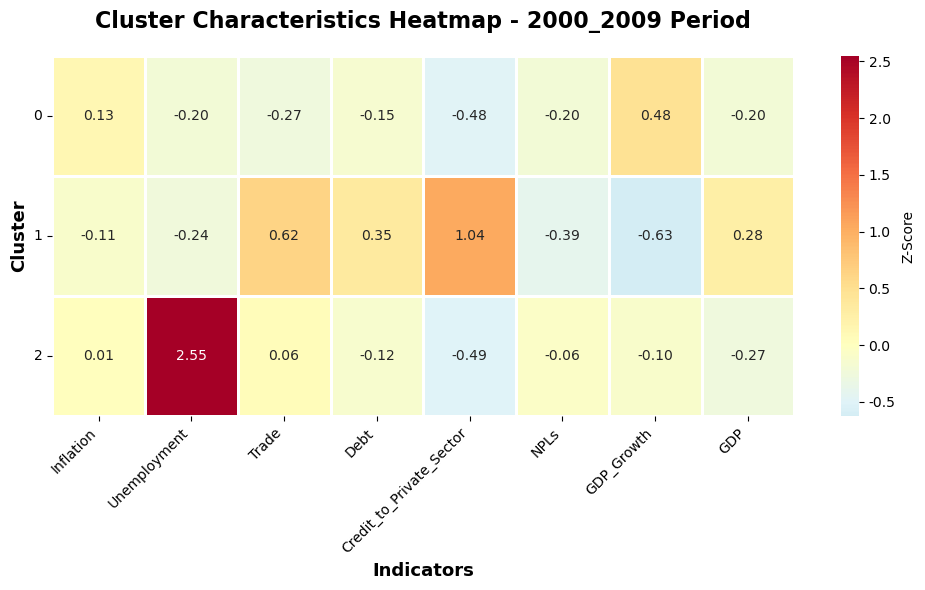

Heatmap saved: fig/heat_2010_2014.png


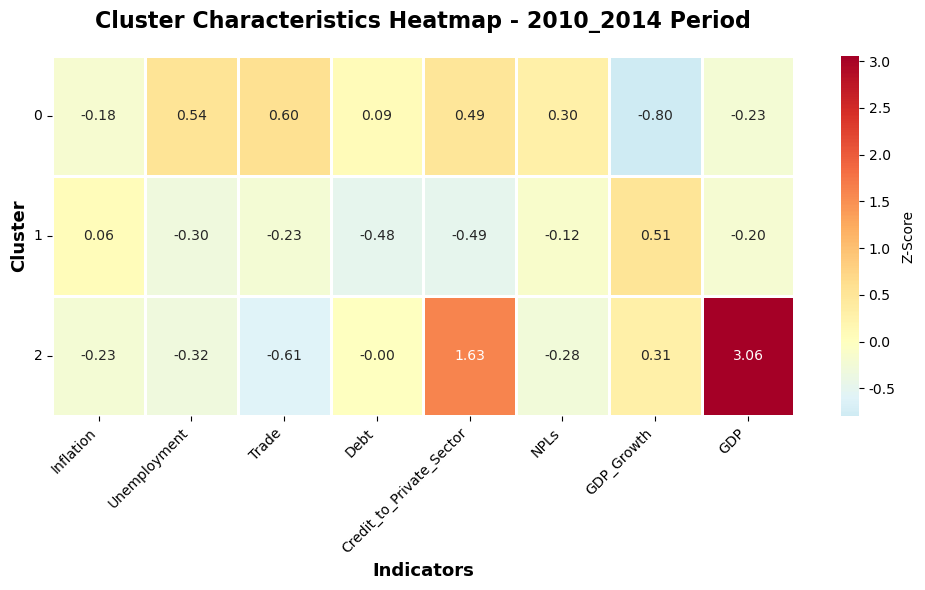

Heatmap saved: fig/heat_2015_2019.png


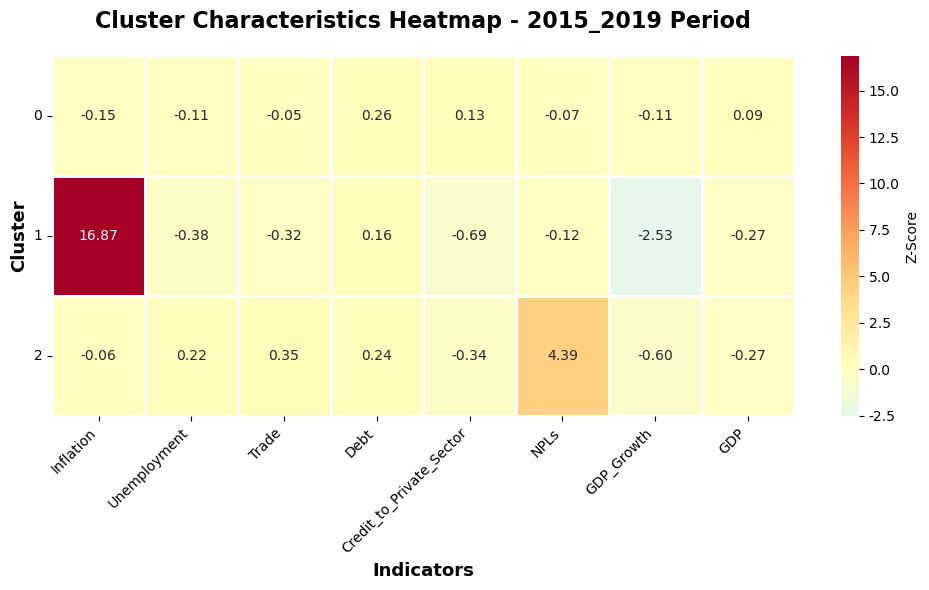

In [19]:
def plot_heatmap(group_means, period_name, filename):
    """
    Plot cluster × indicator heatmap
    """
    plt.figure(figsize=(10, 6))
    
    # Plot heatmap
    sns.heatmap(group_means, annot=True, fmt='.2f', cmap='RdYlBu_r', 
                center=0, linewidths=1, linecolor='white',
                cbar_kws={'label': 'Z-Score'})
    
    plt.title(f'Cluster Characteristics Heatmap - {period_name} Period', 
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Indicators', fontsize=13, fontweight='bold')
    plt.ylabel('Cluster', fontsize=13, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save figure
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Heatmap saved: {filename}")
    plt.show()
# ---- build group_means_std (run this right BEFORE your plot_heatmap calls) ----
import numpy as np
import pandas as pd

def _build_group_means(df_std_win: pd.DataFrame, labels, indicators: list) -> pd.DataFrame:
    tmp = df_std_win[indicators].copy()
    tmp["Cluster"] = pd.Series(np.asarray(labels), index=tmp.index)
    gm = (tmp.groupby("Cluster")[indicators].mean().sort_index())
    return gm

# indicators in stable order
ind_order = [c for c in core_indicators if c in df.columns]

group_means_std = {}

if "df_std" in globals() and "labels_dict" in globals():
    # 3-window path
    for tag in ["2000_2009", "2010_2014", "2015_2019"]:
        if (tag in df_std) and (tag in labels_dict):
            # labels_dict[tag] can be a Series/ndarray or a DataFrame with column "cluster"
            lab = labels_dict[tag]
            if hasattr(lab, "columns") and ("cluster" in lab.columns):
                lab_vals = lab["cluster"].values
            else:
                lab_vals = np.asarray(lab)
            group_means_std[tag] = _build_group_means(df_std[tag], lab_vals, ind_order)
        else:
            print(f"[SKIP] missing df_std or labels for {tag}")
elif all(k in globals() for k in ["df_pre_std", "labels_pre", "df_post_std", "labels_post"]):
    # legacy Pre/Post fallback mapped to windows (will only produce 2 windows)
    group_means_std["2010_2014"] = _build_group_means(df_pre_std,  labels_pre,  ind_order)
    group_means_std["2015_2019"] = _build_group_means(df_post_std, labels_post, ind_order)
else:
    raise NameError("No standardized data + labels available to build group_means_std.")
# ------------------------------------------------------------------------------

plot_heatmap(group_means_std["2000_2009"], "2000_2009", "fig/heat_2000_2009.png")
plot_heatmap(group_means_std["2010_2014"], "2010_2014", "fig/heat_2010_2014.png")
plot_heatmap(group_means_std["2015_2019"], "2015_2019", "fig/heat_2015_2019.png")




### 9.3 Sankey Diagram - Cluster Migration


In [20]:
# ================== Full Sankey diagnose & plot (self-contained) ==================
import os
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly import express as px

RESULTS_DIR = "results"
FIG_DIR = "fig"
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# ----- helper: build migration counts from two labels files -----
def _load_labels(path, country_col="Country Name", label_col="cluster"):
    df = pd.read_csv(path)
    if label_col not in df.columns:
        # allow 'Cluster' from other code paths
        if "Cluster" in df.columns:
            df = df.rename(columns={"Cluster": label_col})
        else:
            raise KeyError(f"Label column not found in {path}.")
    # keep only country + label
    keep = [c for c in [country_col, label_col] if c in df.columns]
    if country_col not in keep:
        # try to detect country col
        cands = [c for c in df.columns if "country" in str(c).lower()]
        if len(cands):
            df = df.rename(columns={cands[0]: country_col})
            keep = [country_col, label_col]
        else:
            raise KeyError(f"Country column not found in {path}.")
    return df[keep].copy()

def _make_migration_edges(labels_a: pd.DataFrame, labels_b: pd.DataFrame,
                          country_col="Country Name", label_col="cluster"):
    merged = labels_a.merge(labels_b, on=country_col, how="inner", suffixes=("_pre","_post"))
    counts = (merged.groupby([f"{label_col}_pre", f"{label_col}_post"])
                    .size()
                    .reset_index(name="count"))
    counts.columns = ["pre_group", "post_group", "count"]
    return counts

# ----- ensure migration edge CSVs exist; if missing, build from labels -----
paths = {
    "lab_00": os.path.join(RESULTS_DIR, "labels_2000_2009.csv"),
    "lab_10": os.path.join(RESULTS_DIR, "labels_2010_2014.csv"),
    "lab_15": os.path.join(RESULTS_DIR, "labels_2015_2019.csv"),
    "mig_1": os.path.join(RESULTS_DIR, "migration_edges_2000_2009_to_2010_2014.csv"),
    "mig_2": os.path.join(RESULTS_DIR, "migration_edges_2010_2014_to_2015_2019.csv"),
}


def _ensure_migration_csv(mig_path, lab_a, lab_b):
    if not os.path.isfile(mig_path):
        if not (os.path.isfile(lab_a) and os.path.isfile(lab_b)):
            raise FileNotFoundError(f"Missing labels to build migration: {lab_a} or {lab_b}")
        la = _load_labels(lab_a)
        lb = _load_labels(lab_b)
        edges = _make_migration_edges(la, lb)
        edges.to_csv(mig_path, index=False, encoding="utf-8-sig")
        print(f"[OK] Built and saved migration edges -> {os.path.abspath(mig_path)}")
    else:
        print(f"[OK] Found migration edges -> {os.path.abspath(mig_path)}")

_ensure_migration_csv(paths["mig_1"], paths["lab_00"], paths["lab_10"])
_ensure_migration_csv(paths["mig_2"], paths["lab_10"], paths["lab_15"])

# ========= SECTION A: label maps & migrated countries (for what-if later) =========
# load labels (guaranteed to have columns: "Country Name", "cluster")
lab_00 = _load_labels(paths["lab_00"])
lab_10 = _load_labels(paths["lab_10"])
lab_15 = _load_labels(paths["lab_15"])

map_00 = lab_00.set_index("Country Name")["cluster"]
map_10 = lab_10.set_index("Country Name")["cluster"]
map_15 = lab_15.set_index("Country Name")["cluster"]

# countries present in both periods
c_00_10 = set(map_00.index) & set(map_10.index)
c_10_15 = set(map_10.index) & set(map_15.index)

# migrated countries (changed cluster id across windows)
migr_00_10 = sorted([c for c in c_00_10 if int(map_00.loc[c]) != int(map_10.loc[c])])
migr_10_15 = sorted([c for c in c_10_15 if int(map_10.loc[c]) != int(map_15.loc[c])])

print(f"[A] migrated 2000_2009→2010_2014: {len(migr_00_10)} countries")
print(f"[A] migrated 2010_2014→2015_2019: {len(migr_10_15)} countries")
# ===========================================================================




[OK] Found migration edges -> /Users/ethan/5048/Untitled Folder/results/migration_edges_2000_2009_to_2010_2014.csv
[OK] Found migration edges -> /Users/ethan/5048/Untitled Folder/results/migration_edges_2010_2014_to_2015_2019.csv
[A] migrated 2000_2009→2010_2014: 211 countries
[A] migrated 2010_2014→2015_2019: 168 countries


[PREP] Ready: df_std keys -> ['2000_2009', '2010_2014', '2015_2019']
[PREP] Ready: kmeans keys -> ['2000_2009', '2010_2014', '2015_2019']


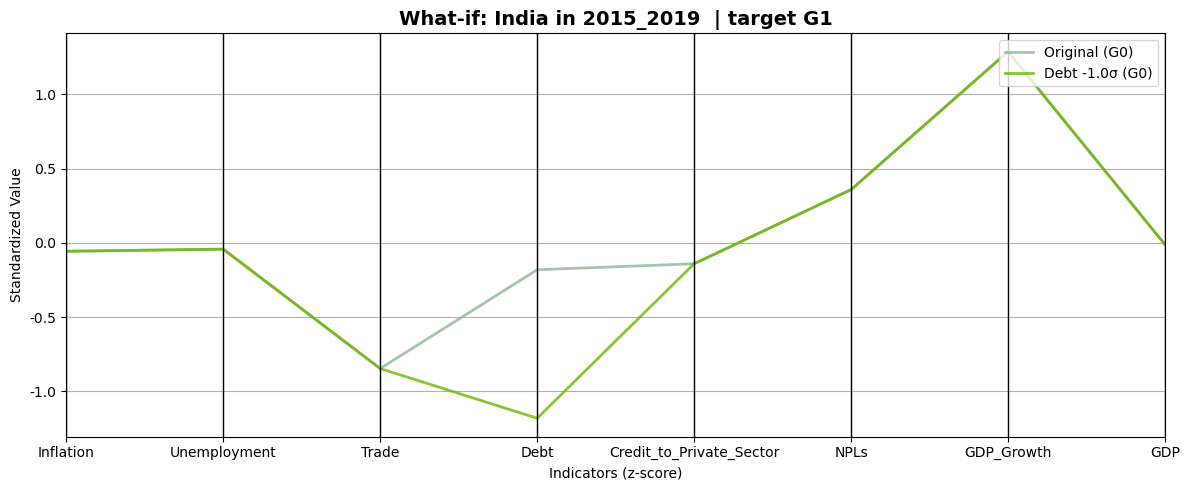

[B][OK] saved fig/what_if_parallel_India_2015_2019.png | old=0 new=0 target=1


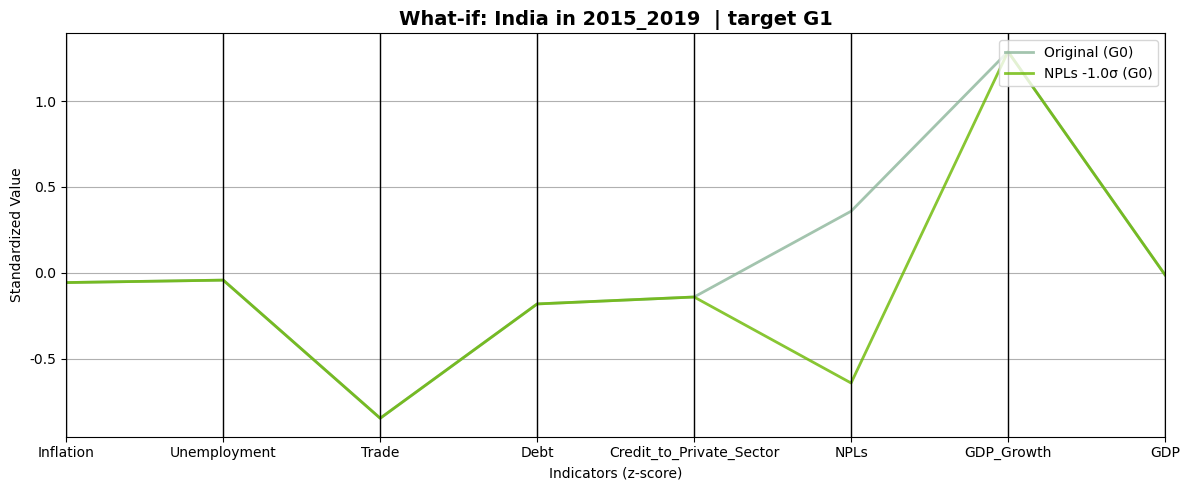

[B][OK] saved fig/what_if_parallel_India_2015_2019.png | old=0 new=0 target=1


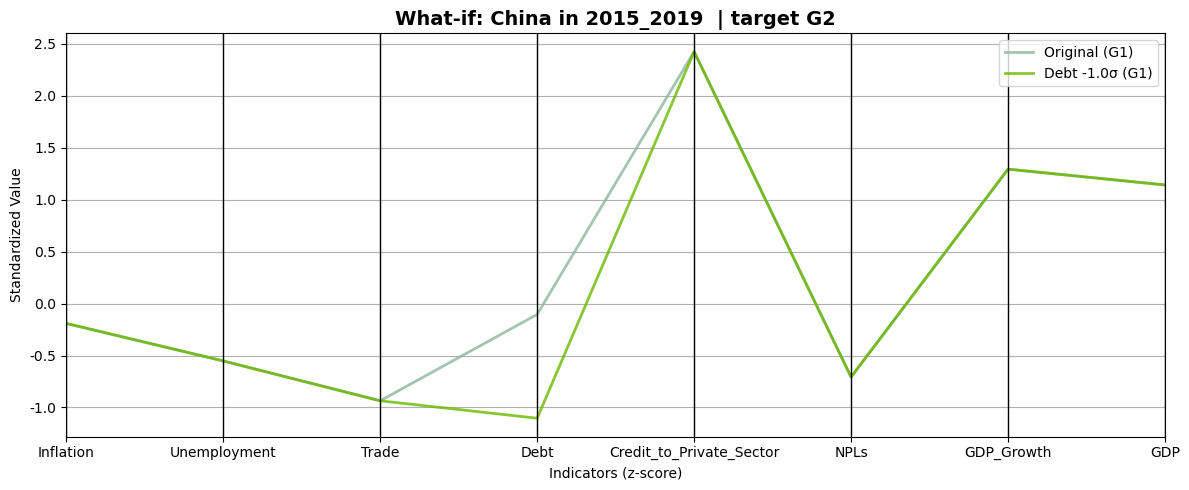

[B][OK] saved fig/what_if_parallel_China_2015_2019.png | old=1 new=1 target=2


[B][OK] saved fig/what_if_parallel_China_2015_2019.png | old=1 new=1 target=2


[B][OK] saved fig/what_if_parallel_Germany_2015_2019.png | old=0 new=0 target=0


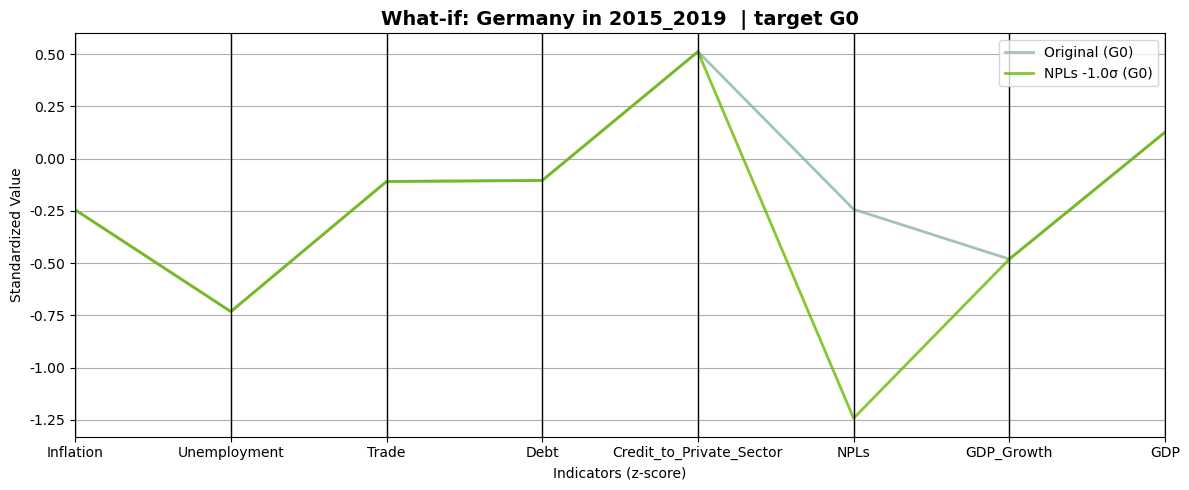

[B][OK] saved fig/what_if_parallel_Germany_2015_2019.png | old=0 new=0 target=0


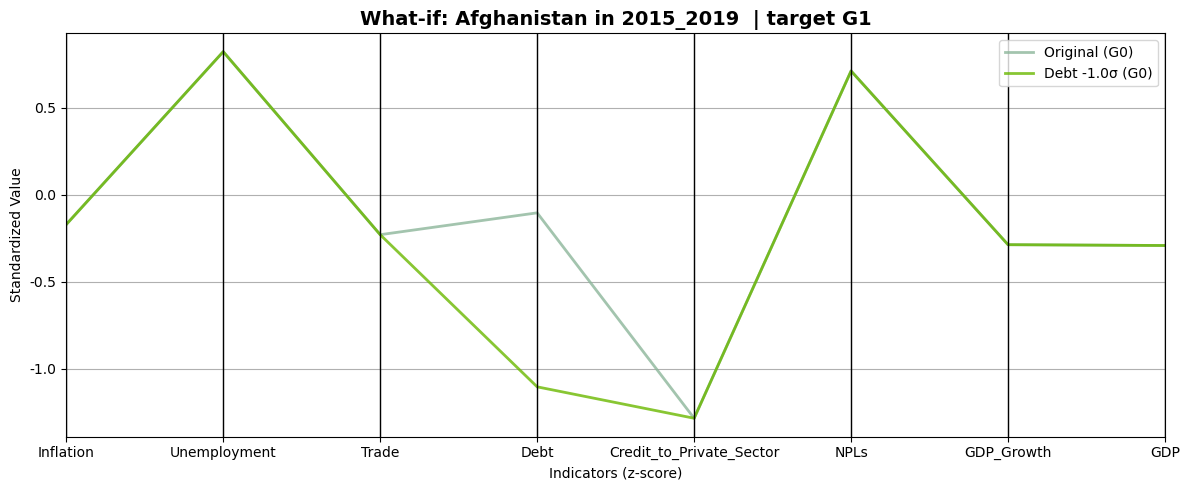

[B][OK] saved fig/what_if_parallel_Afghanistan_2015_2019.png | old=0 new=0 target=1


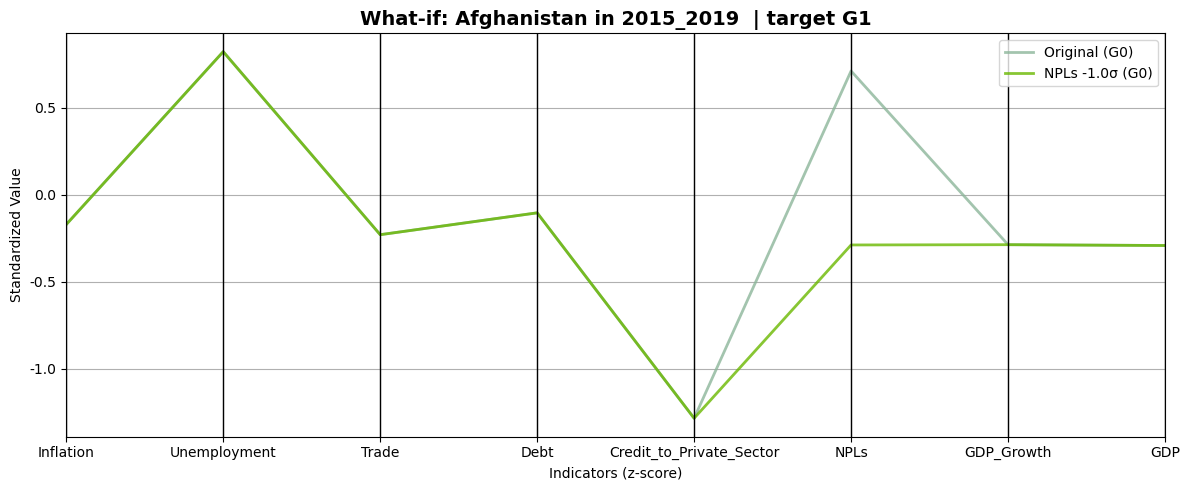

[B][OK] saved fig/what_if_parallel_Afghanistan_2015_2019.png | old=0 new=0 target=1


In [21]:
# ========= SECTION B: what-if parallel coordinates per country =========
from pandas.plotting import parallel_coordinates
import matplotlib.pyplot as plt
import os
# ========= PREP: ensure df_std{} and kmeans{} exist before SECTION B =========
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

WINDOW_TAGS = ["2000_2009", "2010_2014", "2015_2019"]

# require core_indicators list
assert 'core_indicators' in globals(), "core_indicators not defined."

# create dicts if missing
if 'df_std' not in globals() or not isinstance(globals().get('df_std'), dict):
    df_std = {}
if 'kmeans' not in globals() or not isinstance(globals().get('kmeans'), dict):
    kmeans = {}

def _load_or_pick_frame(tag):
    """
    Try load data/clean_<tag>.csv; if not exists, fall back to df_win_clean[tag] 
    (if your earlier pipeline kept it in memory).
    """
    p = f"data/clean_{tag}.csv"
    if os.path.isfile(p):
        d = pd.read_csv(p)
    elif 'df_win_clean' in globals() and tag in df_win_clean:
        d = df_win_clean[tag].copy()
    else:
        raise FileNotFoundError(f"Cannot find data for {tag}. Expected {p} or df_win_clean['{tag}'].")
    # ensure country col
    if "Country Name" not in d.columns:
        # try to detect
        cand = [c for c in d.columns if "country" in str(c).lower()]
        if cand:
            d = d.rename(columns={cand[0]: "Country Name"})
        else:
            raise KeyError(f"'Country Name' column missing in {tag} frame.")
    return d

for tag in WINDOW_TAGS:
    # skip if already present
    if tag in df_std and tag in kmeans:
        continue

    df_tag = _load_or_pick_frame(tag).copy()

    # keep only available indicators
    cols_avail = [c for c in core_indicators if c in df_tag.columns]
    if len(cols_avail) == 0:
        raise ValueError(f"No core indicators found in {tag}.")

    # median impute
    for c in cols_avail:
        med = df_tag[c].median(skipna=True)
        df_tag[c] = df_tag[c].fillna(med)

    # z-score
    scaler = StandardScaler()
    Xz = scaler.fit_transform(df_tag[cols_avail])
    df_std_tag = pd.DataFrame(Xz, columns=cols_avail)
    df_std_tag.insert(0, "Country Name", df_tag["Country Name"].values)

    # fit a minimal KMeans (k=3 by default; change if your project uses a different k)
    km = KMeans(n_clusters=3, random_state=42, n_init=10)
    km.fit(df_std_tag[cols_avail])

    # store
    df_std[tag] = df_std_tag
    kmeans[tag] = km

print("[PREP] Ready: df_std keys ->", list(df_std.keys()))
print("[PREP] Ready: kmeans keys ->", list(kmeans.keys()))

def what_if_parallel(country, post_tag="2015_2019", pre_tag="2010_2014",
                     indicator="Debt", delta_sigma=-1.0, out_dir="fig"):
    os.makedirs(out_dir, exist_ok=True)
    assert post_tag in df_std and pre_tag in df_std, "df_std dict missing required windows."
    assert post_tag in kmeans, "kmeans dict missing required window."

    # rows
    row_post = df_std[post_tag].loc[df_std[post_tag]["Country Name"]==country].copy()
    if row_post.empty:
        print(f"[B][SKIP] {country} not in {post_tag}")
        return
    row_edit = row_post.copy()
    if indicator not in row_edit.columns:
        print(f"[B][SKIP] indicator {indicator} not in frame.")
        return
    row_edit.loc[:, indicator] = row_edit[indicator] + float(delta_sigma)

    # predict before/after
    old_lab = int(kmeans[post_tag].predict(row_post[core_indicators])[0])
    new_lab = int(kmeans[post_tag].predict(row_edit[core_indicators])[0])
    target_lab = int(map_10.loc[country]) if country in map_10.index else old_lab  # aim to stay in pre_tag cluster

    # build plot data
    plot_df = pd.concat([
        row_post[["Country Name"] + core_indicators].assign(Version=f"Original (G{old_lab})"),
        row_edit[["Country Name"] + core_indicators].assign(Version=f"{indicator} {delta_sigma:+.1f}σ (G{new_lab})")
    ], ignore_index=True).drop(columns=["Country Name"])

    plt.figure(figsize=(12,5))
    parallel_coordinates(plot_df, "Version", alpha=0.8, linewidth=2.0)
    plt.title(f"What-if: {country} in {post_tag}  | target G{target_lab}", fontsize=14, fontweight="bold")
    plt.xlabel("Indicators (z-score)"); plt.ylabel("Standardized Value")
    plt.tight_layout()
    out_png = os.path.join(out_dir, f"what_if_parallel_{country.replace(' ','_')}_{post_tag}.png")
    plt.savefig(out_png, dpi=300, bbox_inches="tight"); plt.show()
    print(f"[B][OK] saved {out_png} | old={old_lab} new={new_lab} target={target_lab}")

# examples (edit if needed)
for c in ["India", "China", "Germany", "Afghanistan"]:
    what_if_parallel(country=c, post_tag="2015_2019", pre_tag="2010_2014", indicator="Debt",  delta_sigma=-1.0)
    what_if_parallel(country=c, post_tag="2015_2019", pre_tag="2010_2014", indicator="NPLs", delta_sigma=-1.0)


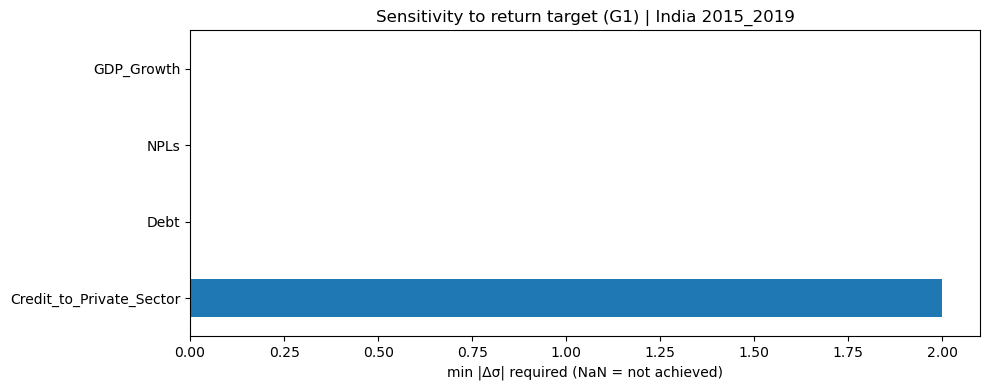

[C][OK] saved fig/what_if_sensitivity_India_2015_2019.png


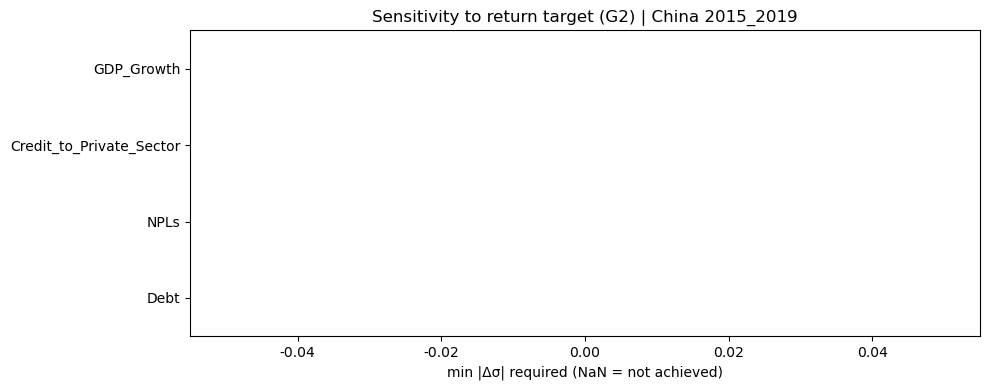

[C][OK] saved fig/what_if_sensitivity_China_2015_2019.png


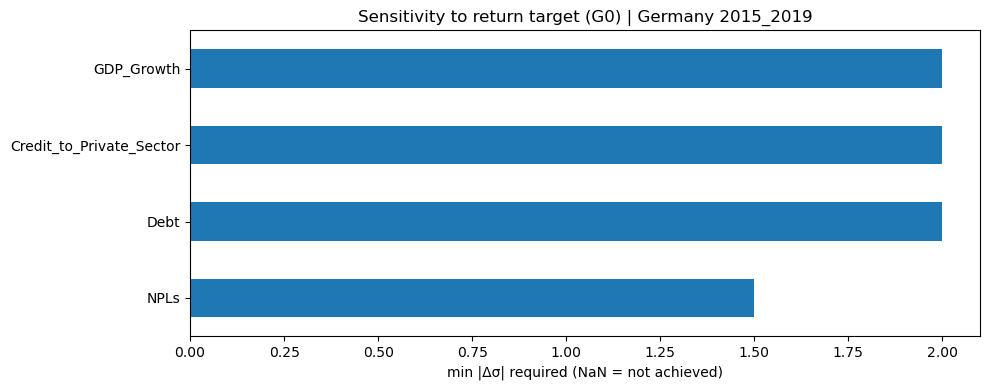

[C][OK] saved fig/what_if_sensitivity_Germany_2015_2019.png


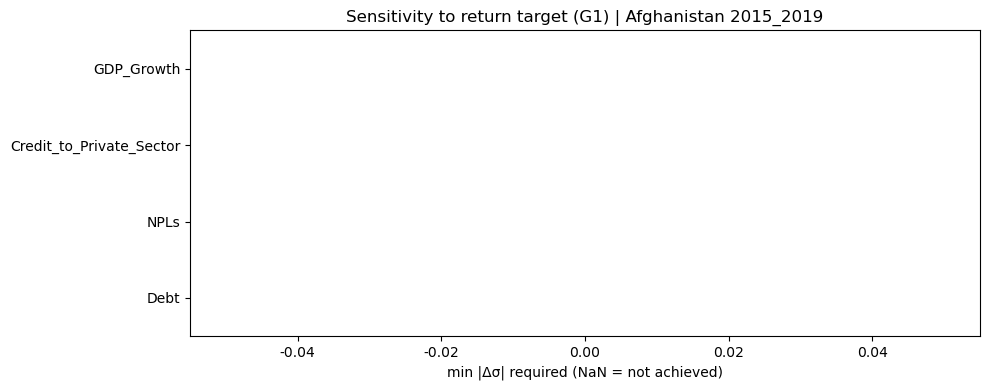

[C][OK] saved fig/what_if_sensitivity_Afghanistan_2015_2019.png


In [22]:
# ========= SECTION C: per-country indicator sensitivity (min |Δσ| to return) =========
import numpy as np

def sensitivity_bar(country, post_tag="2015_2019", pre_tag="2010_2014",
                    indicators=None, deltas=None, out_dir="fig"):
    os.makedirs(out_dir, exist_ok=True)
    if indicators is None:
        indicators = core_indicators
    if deltas is None:
        deltas = [-2.0, -1.5, -1.0, -0.5, 0.5, 1.0, 1.5, 2.0]

    row_post = df_std[post_tag].loc[df_std[post_tag]["Country Name"]==country].copy()
    if row_post.empty:
        print(f"[C][SKIP] {country} not in {post_tag}")
        return
    target_lab = int(map_10.loc[country]) if country in map_10.index else None
    if target_lab is None:
        print(f"[C][SKIP] {country} no target label in {pre_tag}")
        return

    mins = []
    for ind in indicators:
        if ind not in row_post.columns: 
            continue
        need = None
        for d in deltas:
            row_edit = row_post.copy()
            row_edit.loc[:, ind] = row_edit[ind] + float(d)
            lab = int(kmeans[post_tag].predict(row_edit[core_indicators])[0])
            if lab == target_lab:
                need = abs(d); break
        mins.append((ind, need if need is not None else np.nan))

    # bar plot
    vals = pd.Series({k:v for k,v in mins}).sort_values(na_position="last")
    plt.figure(figsize=(10,4))
    vals.plot(kind="barh")
    plt.title(f"Sensitivity to return target (G{target_lab}) | {country} {post_tag}")
    plt.xlabel("min |Δσ| required (NaN = not achieved)"); plt.tight_layout()
    out_png = os.path.join(out_dir, f"what_if_sensitivity_{country.replace(' ','_')}_{post_tag}.png")
    plt.savefig(out_png, dpi=300, bbox_inches="tight"); plt.show()
    print(f"[C][OK] saved {out_png}")

# example
for c in ["India", "China", "Germany", "Afghanistan"]:
    sensitivity_bar(c, post_tag="2015_2019", pre_tag="2010_2014",
                    indicators=["Debt","NPLs","Credit_to_Private_Sector","GDP_Growth"])


In [23]:
# ----- plotting function (always saves HTML; PNG if kaleido available) -----
def plot_sankey(migration_edges: pd.DataFrame, filename: str, pre_tag: str, post_tag: str):
    out_png  = os.path.abspath(filename)
    out_html = os.path.abspath(filename.replace(".png", ".html"))
    os.makedirs(os.path.dirname(out_png) or ".", exist_ok=True)

    # empty placeholder
    if migration_edges is None or len(migration_edges) == 0:
        fig = go.Figure()
        fig.update_layout(
            title=dict(text=f"Cluster Migration: {pre_tag} → {post_tag} (NO DATA)", font=dict(size=20)),
            height=320, width=640, paper_bgcolor="white", plot_bgcolor="white"
        )
        fig.write_html(out_html)
        print(f"[WARN] Empty edges. Saved placeholder HTML -> {out_html}")
        try:
            fig.write_image(out_png, width=640, height=320, scale=2)
            print(f"[OK] Placeholder PNG -> {out_png}")
        except Exception as e:
            print(f"[WARN] PNG export failed (placeholder): {e}")
        return

    edges = migration_edges.copy()
    edges["pre_group"]  = edges["pre_group"].astype(int)
    edges["post_group"] = edges["post_group"].astype(int)

    edges["count"]      = edges["count"].astype(int)

    pre_ids  = sorted(edges["pre_group"].unique().tolist())
    post_ids = sorted(edges["post_group"].unique().tolist())
    p, q = len(pre_ids), len(post_ids)

    pre_labels  = [f"{pre_tag}-G{i}"  for i in pre_ids]
    post_labels = [f"{post_tag}-G{j}" for j in post_ids]
    node_labels = pre_labels + post_labels

    pre_idx  = {g: i for i, g in enumerate(pre_ids)}
    post_idx = {g: p + j for j, g in enumerate(post_ids)}

    src = [pre_idx[int(r.pre_group)]   for _, r in edges.iterrows()]
    tgt = [post_idx[int(r.post_group)] for _, r in edges.iterrows()]
    val = [int(r["count"])             for _, r in edges.iterrows()]

    palette = px.colors.qualitative.Plotly + px.colors.qualitative.Dark24 + px.colors.qualitative.Set3
    node_colors = (palette * ((p + q + len(palette) - 1)//len(palette)))[:p+q]

    fig = go.Figure(data=[go.Sankey(
        node=dict(

            pad=14, thickness=18,
            line=dict(color="black", width=0.5),
            label=node_labels,
            color=node_colors
        ),
        link=dict(source=src, target=tgt, value=val)
    )])

    fig.update_layout(
        title=dict(text=f"Cluster Migration: {pre_tag} → {post_tag}", font=dict(size=20)),
        font=dict(size=12),
        plot_bgcolor="white",
        paper_bgcolor="white",
        height=580, width=980
    )

    # save
    try:
        fig.write_image(out_png, width=980, height=580, scale=2)  # requires kaleido
        print(f"[OK] PNG saved -> {out_png}")
    except Exception as e:
        print(f"[WARN] PNG export failed: {e}")

    fig.write_html(out_html)
    print(f"[OK] HTML saved -> {out_html}")


    fig.show()

# ----- load migrations and plot two transitions -----
mig1 = pd.read_csv(paths["mig_1"])
mig2 = pd.read_csv(paths["mig_2"])

plot_sankey(mig1, os.path.join(FIG_DIR, "sankey_2000_2009_to_2010_2014.png"), "2000_2009", "2010_2014")
plot_sankey(mig2, os.path.join(FIG_DIR, "sankey_2010_2014_to_2015_2019.png"), "2010_2014", "2015_2019")

# diagnostic prints
print("CWD:", os.path.abspath(os.getcwd()))
print("Files created (expected):")
print(" -", os.path.abspath(os.path.join(FIG_DIR, "sankey_2000_2009_to_2010_2014.png")))
print(" -", os.path.abspath(os.path.join(FIG_DIR, "sankey_2000_2009_to_2010_2014.html")))
print(" -", os.path.abspath(os.path.join(FIG_DIR, "sankey_2010_2014_to_2015_2019.png")))
print(" -", os.path.abspath(os.path.join(FIG_DIR, "sankey_2010_2014_to_2015_2019.html")))
# =====================================================================

[WARN] PNG export failed: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

[OK] HTML saved -> /Users/ethan/5048/Untitled Folder/fig/sankey_2000_2009_to_2010_2014.html


[WARN] PNG export failed: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

[OK] HTML saved -> /Users/ethan/5048/Untitled Folder/fig/sankey_2010_2014_to_2015_2019.html


CWD: /Users/ethan/5048/Untitled Folder
Files created (expected):
 - /Users/ethan/5048/Untitled Folder/fig/sankey_2000_2009_to_2010_2014.png
 - /Users/ethan/5048/Untitled Folder/fig/sankey_2000_2009_to_2010_2014.html
 - /Users/ethan/5048/Untitled Folder/fig/sankey_2010_2014_to_2015_2019.png
 - /Users/ethan/5048/Untitled Folder/fig/sankey_2010_2014_to_2015_2019.html


In [24]:
# ========= SECTION D: counterfactual sankey (after applying what-if) =========
import glob, os
import plotly.graph_objects as go
from plotly import express as px

# collect countries that can be pulled back in 2015_2019 (from SECTION B/C logic)
# collect counterfactual changes by searching indicators & deltas
cf_changes = {}   # country -> (indicator, delta_sigma, new_lab)
cf_target  = {}   # country -> target pre cluster
test_countries = ["India", "China", "Germany", "Afghanistan"]
test_inds   = [i for i in ["Debt","NPLs","Credit_to_Private_Sector","GDP_Growth","Inflation","Unemployment","Trade","GDP"] if i in core_indicators]
test_deltas = (-2.5,-2.0,-1.5,-1.0,-0.5,0.5,1.0,1.5,2.0,2.5)

for c in test_countries:
    row_post = df_std["2015_2019"].loc[df_std["2015_2019"]["Country Name"]==c].copy()
    if row_post.empty or c not in map_10.index:
        continue
    target = int(map_10.loc[c])
    for ind in test_inds:
        for d in test_deltas:
            row_edit = row_post.copy()
            row_edit.loc[:, ind] = row_edit[ind] + d
            new_lab = int(kmeans["2015_2019"].predict(row_edit[core_indicators])[0])
            if new_lab == target:
                cf_changes[c] = (ind, d, new_lab)
                cf_target[c]  = target
                break
        if c in cf_changes:  # found for this country
            break

print("[D] counterfactual candidates:", cf_changes)
if len(cf_changes) == 0:
    print("[D][WARN] no country can be pulled back under current search; counterfactual == original.")


# load original edges 2010->2015
edges = pd.read_csv("results/migration_edges_2010_2014_to_2015_2019.csv")
labels_10 = _load_labels(paths["lab_10"])[["Country Name","cluster"]].rename(columns={"cluster":"pre"})
labels_15 = _load_labels(paths["lab_15"])[["Country Name","cluster"]].rename(columns={"cluster":"post"})

m = labels_10.merge(labels_15, on="Country Name", how="inner")

# apply counterfactual: reassign cf_ok to target pre cluster in 2015_2019

m_cf = m.copy()
for c, (_ind, _d, _newlab) in cf_changes.items():
    m_cf.loc[m_cf["Country Name"]==c, "post"] = cf_target[c]


# rebuild edges
def _edges_from(df):
    t = (df.groupby(["pre","post"]).size().reset_index(name="count")
           .rename(columns={"pre":"pre_group","post":"post_group"}))
    t["pre_group"] = t["pre_group"].astype(int); t["post_group"]=t["post_group"].astype(int)
    return t

edges_cf = _edges_from(m_cf)
edges.to_csv("results/migration_edges_2010_2014_to_2015_2019_original.csv", index=False, encoding="utf-8-sig")
edges_cf.to_csv("results/migration_edges_2010_2014_to_2015_2019_counterfactual.csv", index=False, encoding="utf-8-sig")

def plot_sankey_from_edges(df_edges, filename, pre_tag, post_tag):
    pre_ids = sorted(df_edges["pre_group"].unique().tolist())
    post_ids= sorted(df_edges["post_group"].unique().tolist())
    p, q = len(pre_ids), len(post_ids)
    pre_labels  = [f"{pre_tag}-G{i}"  for i in pre_ids]
    post_labels = [f"{post_tag}-G{j}" for j in post_ids]
    pre_idx  = {g:i for i,g in enumerate(pre_ids)}
    post_idx = {g:p+j for j,g in enumerate(post_ids)}
    src = [pre_idx[int(r.pre_group)] for _,r in df_edges.iterrows()]
    tgt = [post_idx[int(r.post_group)] for _,r in df_edges.iterrows()]
    val = [int(r["count"]) for _,r in df_edges.iterrows()]
    palette = px.colors.qualitative.Plotly + px.colors.qualitative.Set3
    node_colors = (palette * ((p+q+len(palette)-1)//len(palette)))[:p+q]
    fig = go.Figure(data=[go.Sankey(
        node=dict(pad=14, thickness=18, line=dict(color="black", width=0.5),
                  label=pre_labels+post_labels, color=node_colors),
        link=dict(source=src, target=tgt, value=val)
    )])
    fig.update_layout(title=f"Sankey: {pre_tag} → {post_tag}", height=580, width=980)
    os.makedirs(os.path.dirname(filename) or ".", exist_ok=True)
    try:
        fig.write_image(filename, width=980, height=580, scale=2)
        print(f"[D][OK] PNG -> {os.path.abspath(filename)}")
    except Exception as e:
        print(f"[D][WARN] PNG export failed: {e}")
    fig.write_html(filename.replace(".png", ".html"))
    print(f"[D][OK] HTML -> {os.path.abspath(filename).replace('.png','.html')}")
    fig.show()

plot_sankey_from_edges(edges,   "fig/sankey_2010_2014_to_2015_2019_original.png",       "2010_2014","2015_2019")
plot_sankey_from_edges(edges_cf,"fig/sankey_2010_2014_to_2015_2019_counterfactual.png", "2010_2014","2015_2019")


[D] counterfactual candidates: {'India': ('Credit_to_Private_Sector', 2.0, 1), 'Germany': ('Debt', -2.5, 0)}
[D][WARN] PNG export failed: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

[D][OK] HTML -> /Users/ethan/5048/Untitled Folder/fig/sankey_2010_2014_to_2015_2019_original.html


[D][WARN] PNG export failed: 
Image export using the "kaleido" engine requires the kaleido package,
which can be installed using pip:
    $ pip install -U kaleido

[D][OK] HTML -> /Users/ethan/5048/Untitled Folder/fig/sankey_2010_2014_to_2015_2019_counterfactual.html


[CF] candidates: 257, rescued: 168
[CF] examples: ['Africa Eastern and Southern', 'Albania', 'American Samoa', 'Andorra', 'Antigua and Barbuda', 'Arab World', 'Armenia', 'Aruba', 'Australia', 'Austria']


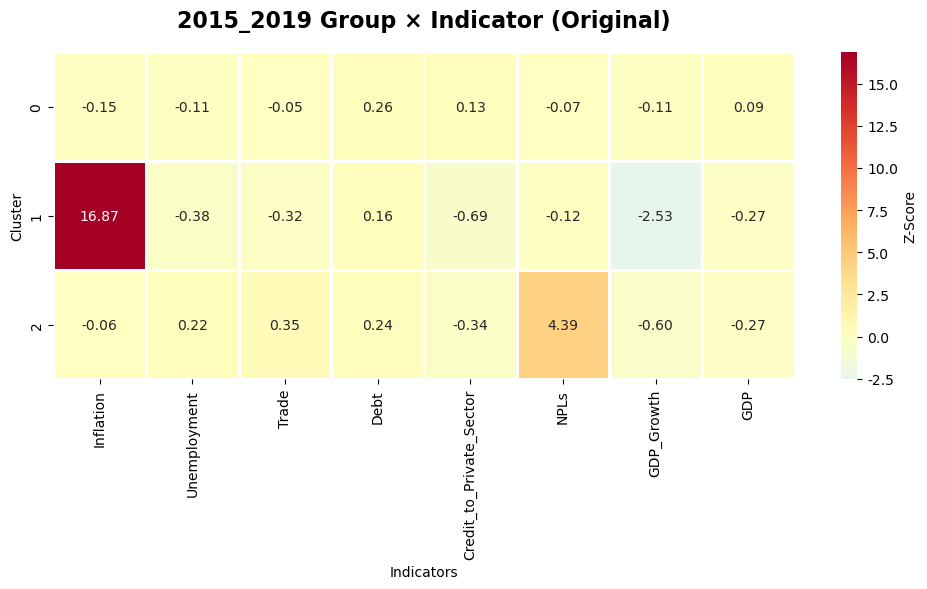

[E][OK] saved fig/heat_2015_2019_original.png


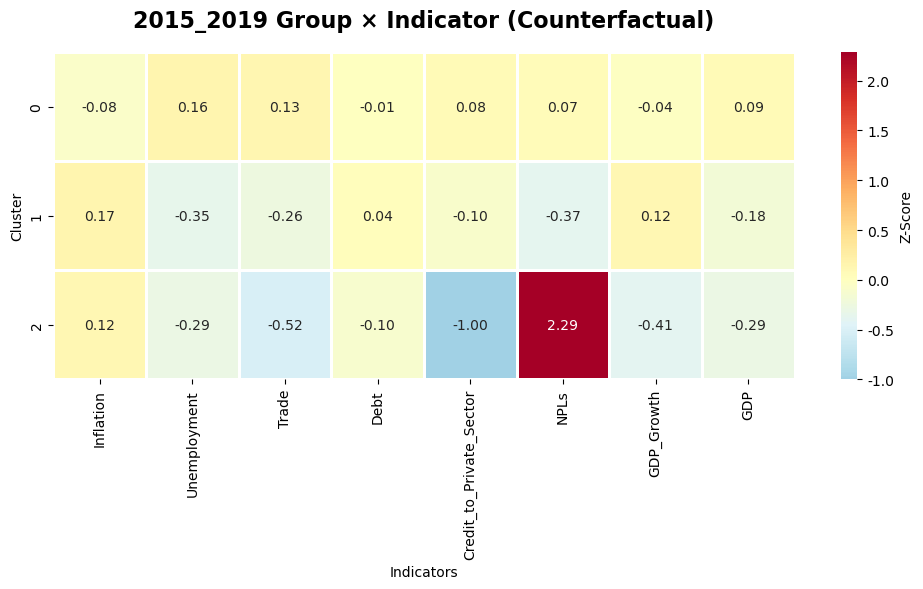

[E][OK] saved fig/heat_2015_2019_counterfactual.png


In [25]:
# ========= SECTION E: counterfactual heatmap for 2015_2019 =========
import seaborn as sns

def plot_group_heatmap(df_means, title, outfile):
    plt.figure(figsize=(10,6))
    sns.heatmap(df_means, annot=True, fmt=".2f", cmap="RdYlBu_r", center=0,
                linewidths=1, linecolor="white", cbar_kws={"label":"Z-Score"})
    plt.title(title, fontsize=16, fontweight="bold", pad=18)
    plt.xlabel("Indicators"); plt.ylabel("Cluster"); plt.tight_layout()
    os.makedirs(os.path.dirname(outfile) or ".", exist_ok=True)
    plt.savefig(outfile, dpi=300, bbox_inches="tight"); plt.show()
    print(f"[E][OK] saved {outfile}")

# original group means (standardized)
gm15 = pd.read_csv("results/group_means_2015_2019.csv", index_col=0)
# ---- ensure cf_ok / cf_target exist before using them ----
import numpy as np

post_tag = "2015_2019"
pre_tag  = "2010_2014"

if "map_10" not in globals():
    _lab10 = pd.read_csv("results/labels_2010_2014.csv")
    if "cluster" not in _lab10.columns and "Cluster" in _lab10.columns:
        _lab10 = _lab10.rename(columns={"Cluster": "cluster"})
    map_10 = _lab10.set_index("Country Name")["cluster"]

if "cf_ok" not in globals() or "cf_target" not in globals():
    cf_ok = set()
    cf_target = {}

    # candidates = 国家交集（有2010_2014标签且在2015_2019标准化表里）
    cand_a = set(map_10.index)
    cand_b = set(df_std[post_tag]["Country Name"]) if post_tag in df_std else set()
    candidates = sorted(cand_a & cand_b)

    # 允许尝试的单指标及改动步长（先小后大，双向）
    try_inds = [c for c in [
        "Debt", "NPLs", "Credit_to_Private_Sector", "GDP_Growth",
        "Inflation", "Unemployment", "Trade", "GDP"
    ] if c in core_indicators]

    base = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
    deltas = [d for pair in ((b, -b) for b in base) for d in pair]  # +b, -b 交替

    for country in candidates:
        row = df_std[post_tag].loc[df_std[post_tag]["Country Name"] == country].copy()
        if row.empty:
            continue
        target_lab = int(map_10.loc[country])

        success = False
        for ind in try_inds:
            if ind not in row.columns:
                continue
            for d in deltas:
                r = row.copy()
                r.loc[:, ind] = float(r[ind]) + float(d)
                pred = int(kmeans[post_tag].predict(r[core_indicators].to_numpy())[0])
                if pred == target_lab:
                    cf_ok.add(country)
                    cf_target[country] = target_lab
                    success = True
                    break
            if success:
                break

    print(f"[CF] candidates: {len(candidates)}, rescued: {len(cf_ok)}")
    if cf_ok:
        print("[CF] examples:", sorted(list(cf_ok))[:10])
# -----------------------------------------------------------

# counterfactual labels for 2015_2019 (start from original)
lab15_cf = lab_15.copy()
for c in cf_ok:
    lab15_cf.loc[lab15_cf["Country Name"]==c, "cluster"] = cf_target[c]

# recompute means with cf labels on standardized frame
X15 = df_std["2015_2019"].merge(lab15_cf, on="Country Name", how="inner")
gm15_cf = (X15.groupby("cluster")[core_indicators].mean()).sort_index()

plot_group_heatmap(gm15,    "2015_2019 Group × Indicator (Original)",        "fig/heat_2015_2019_original.png")
plot_group_heatmap(gm15_cf, "2015_2019 Group × Indicator (Counterfactual)",  "fig/heat_2015_2019_counterfactual.png")


In [26]:
# ---- build a compact migration summary table for report captions ----
import pandas as pd, os

summary_rows = []
for mig_path in [paths["mig_1"], paths["mig_2"]]:
    dfm = pd.read_csv(mig_path)
    total = int(dfm["count"].sum())
    top = dfm.sort_values("count", ascending=False).head(2).copy()
    top["path"] = top["pre_group"].astype(str) + "→" + top["post_group"].astype(str)
    rec = {
        "transition": os.path.basename(mig_path).replace("migration_edges_","").replace(".csv",""),
        "total_moved": total,
        "top1_path": f'{top.iloc[0]["path"]} ({int(top.iloc[0]["count"])})' if len(top)>0 else "",
        "top2_path": f'{top.iloc[1]["path"]} ({int(top.iloc[1]["count"])})' if len(top)>1 else ""
    }
    summary_rows.append(rec)

migration_summary = pd.DataFrame(summary_rows).sort_values("total_moved", ascending=False)
migration_summary.to_csv("results/migration_summary.csv", index=False, encoding="utf-8-sig")
print("\n[OK] wrote results/migration_summary.csv")
print(migration_summary.to_string(index=False))



[OK] wrote results/migration_summary.csv
            transition  total_moved top1_path top2_path
2000_2009_to_2010_2014          257 0→1 (123)  1→0 (43)
2010_2014_to_2015_2019          257 1→0 (132)  0→0 (88)


### 9.4 Line Chart + Changepoint Annotation


Changepoint line chart saved: /Users/ethan/5048/Untitled Folder/fig/changepoint_lines.png


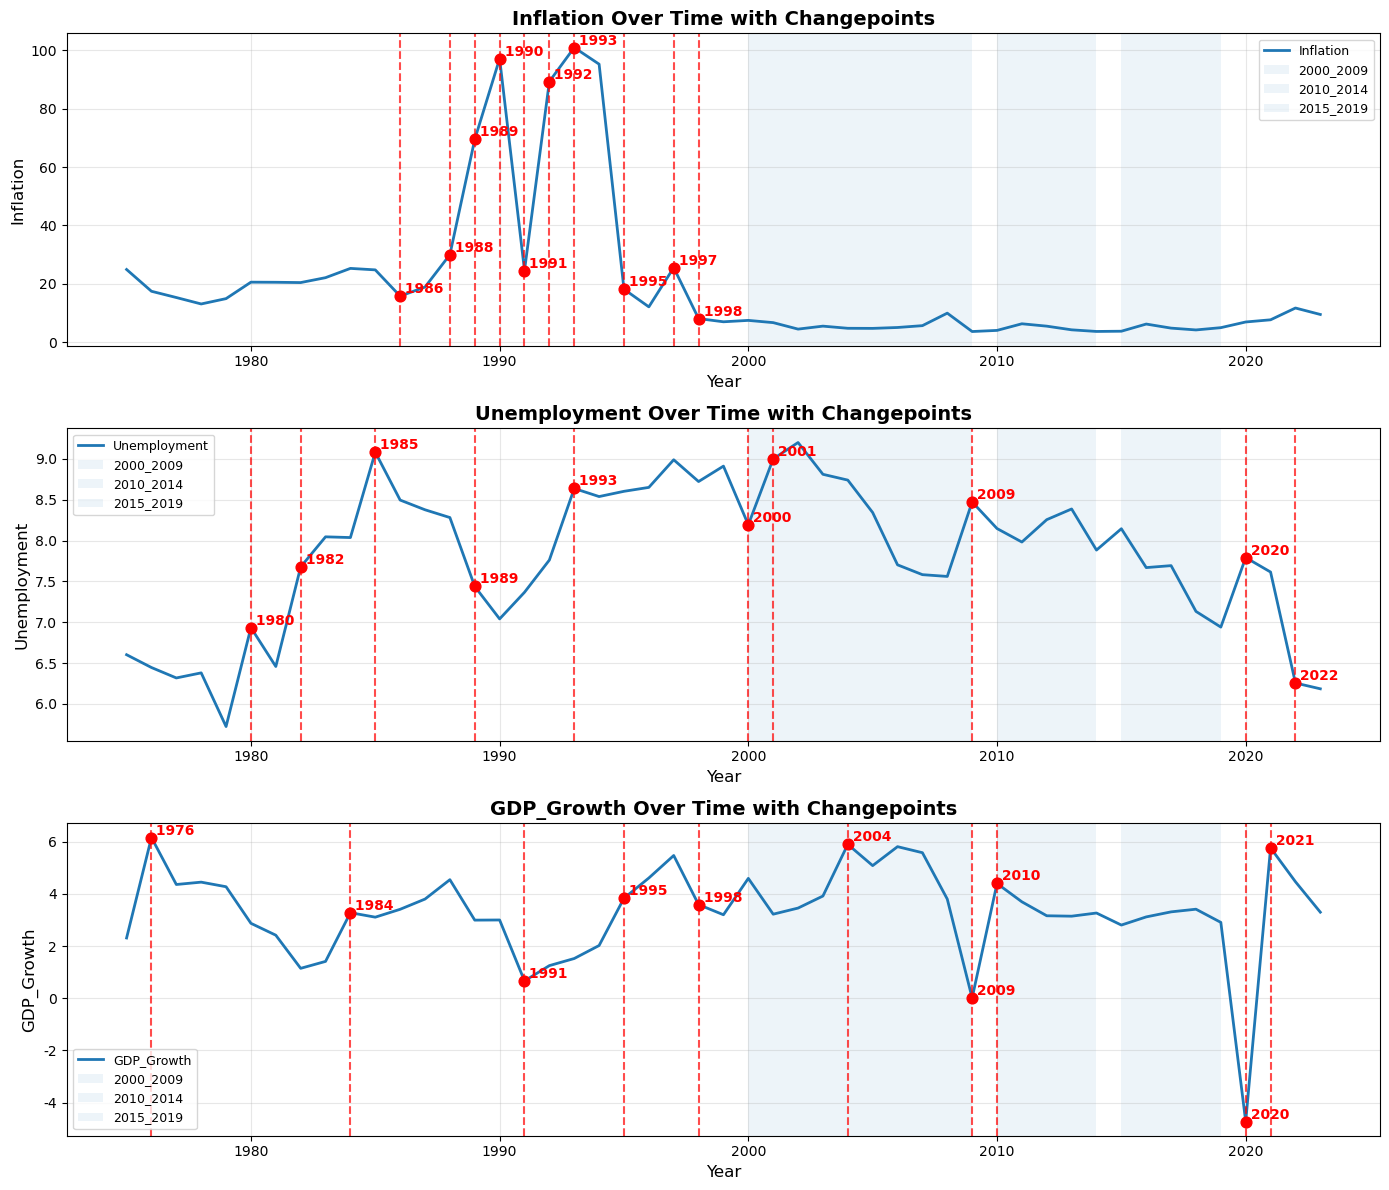

In [27]:
def plot_changepoint_lines(df_yearly, changepoints_dict, filename, indicators=None):
    """
    Plot key indicator lines and annotate changepoints.
    Shades time windows defined by WINDOWS.
    """
    inds = indicators if indicators is not None else changepoint_indicators
    fig, axes = plt.subplots(len(inds), 1, figsize=(14, 4 * len(inds)))
    if len(inds) == 1:
        axes = [axes]

    for idx, indicator in enumerate(inds):
        ax = axes[idx]
        data = df_yearly[['Year', indicator]].dropna().sort_values('Year')
        ax.plot(data['Year'], data[indicator], linewidth=2, label=indicator)

        # annotate changepoints
        cp_years = changepoints_dict.get(indicator, [])
        for cp_year in cp_years:
            if cp_year in data['Year'].values:
                yv = float(data.loc[data['Year'] == cp_year, indicator].iloc[0])
                ax.axvline(x=cp_year, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
                ax.scatter([cp_year], [yv], color='red', s=60, zorder=5)
                ax.text(cp_year, yv, f' {int(cp_year)}', fontsize=10,
                        va='bottom', color='red', fontweight='bold')

        # shade WINDOWS
        for tag, (ys, ye) in WINDOWS.items():
            ax.axvspan(ys, ye, alpha=0.08, label=tag)

        ax.set_title(f'{indicator} Over Time with Changepoints', fontsize=14, fontweight='bold')
        ax.set_xlabel('Year', fontsize=12)
        ax.set_ylabel(indicator, fontsize=12)
        # build a clean legend (unique labels)
        handles, labels = ax.get_legend_handles_labels()
        uniq = dict(zip(labels, handles))
        ax.legend(uniq.values(), uniq.keys(), loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    os.makedirs(os.path.dirname(filename) or ".", exist_ok=True)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"Changepoint line chart saved: {os.path.abspath(filename)}")
    plt.show()

# call
plot_changepoint_lines(df_yearly, changepoints_dict, 'fig/changepoint_lines.png')


Box plot data preview (long-form):
  Country Name  Inflation  Unemployment      Trade     Period
0  Afghanistan   8.768168        2.4940  71.247539  2000-2009
1        China   1.872691        4.0607  51.633286  2000-2009
2      Germany   1.590869        9.0268  65.572131  2000-2009
3        India   5.530636        3.2675  38.355260  2000-2009
4  Afghanistan   6.496741        4.8035  76.844084  2010-2014
Box plot saved: /Users/ethan/5048/Untitled Folder/fig/box_sig_3periods.png


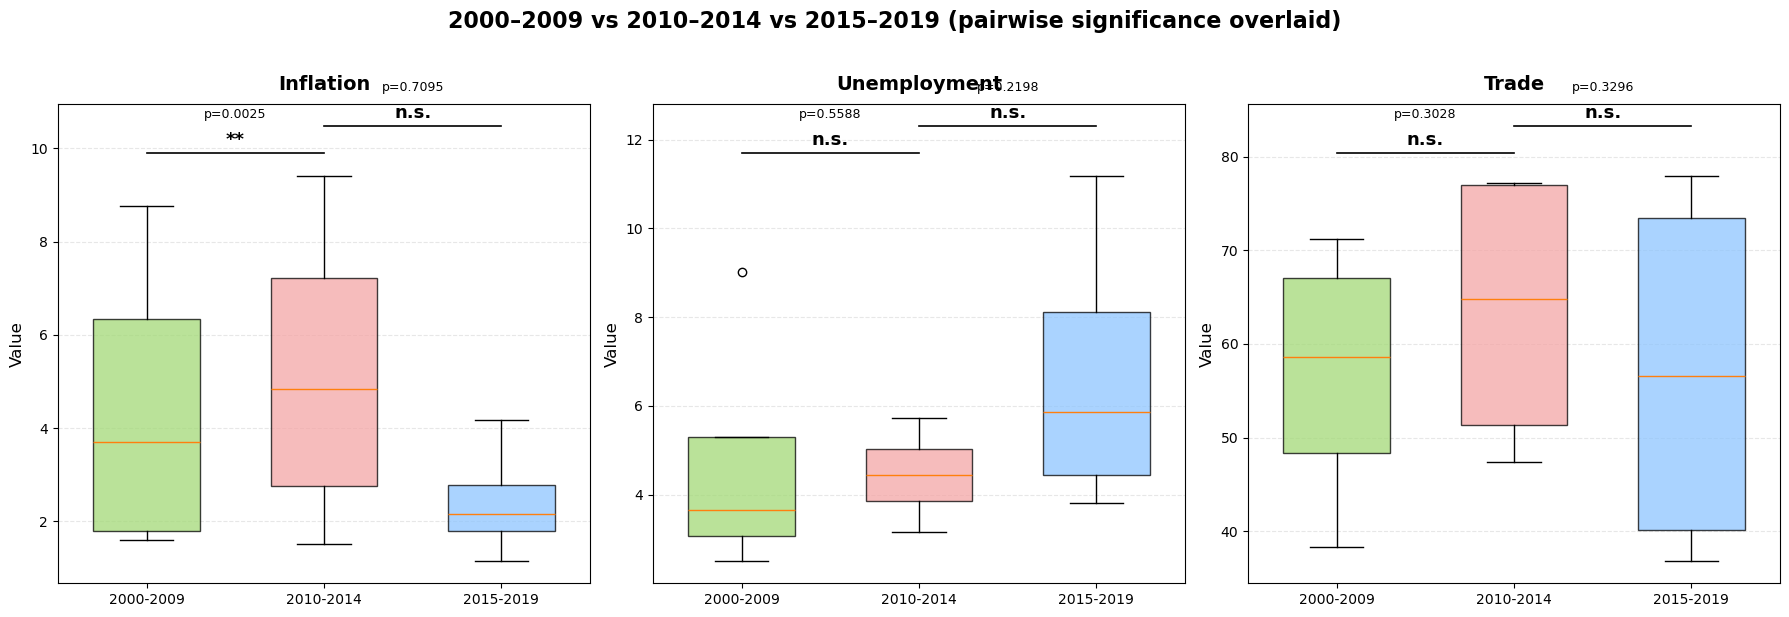

In [28]:
# ==== 3-window boxplots with optional focus-countries and pairwise significance ====
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# windows (three periods)
TAGS = ["2000_2009", "2010_2014", "2015_2019"]

# indicators (use your final 8 if you want all; boxplot subset below)
core_indicators = [
    "Inflation","Unemployment","Trade","Debt",
    "Credit_to_Private_Sector","NPLs","GDP_Growth","GDP"
]
box_indicators = [c for c in ["Inflation","Unemployment","Trade"] if c in core_indicators]

# focus countries (ensure it exists; edit names to your exact spelling in data)
FOCUS_COUNTRIES = ["India", "China", "Germany", "Afghanistan"]

# df_imputed alias if you only have Pre/Post
if "df_imputed" not in globals():
    df_imputed = {}
    if "df_pre_imputed" in globals():  df_imputed["2010_2014"] = df_pre_imputed
    if "df_post_imputed" in globals(): df_imputed["2015_2019"] = df_post_imputed

# ensure "Country Name" column exists in each window frame
def _ensure_country_name(df_):
    if "Country Name" in df_.columns:
        return df_
    d = df_.reset_index()
    for cand in ["Country Name","index","Country","country","Nation","Economy"]:
        if cand in d.columns:
            if cand != "Country Name":
                d = d.rename(columns={cand:"Country Name"})
            return d
    raise KeyError(f"No country column found. Columns: {list(d.columns)}")

for t in list(df_imputed.keys()):
    df_imputed[t] = _ensure_country_name(df_imputed[t])

# normalize stats_summary (column names & add comparison if missing)
if "stats_summary" in globals():
    if "Indicator" in stats_summary.columns:
        stats_summary = stats_summary.rename(columns={"Indicator":"indicator"})
    if "T_PValue" in stats_summary.columns:
        stats_summary = stats_summary.rename(columns={"T_PValue":"t_pvalue"})
    if "comparison" not in stats_summary.columns:
        # fallback: add comparisons for common pairs if missing
        comp = []
        for _ in range(len(stats_summary)):
            comp.append("2010_2014 vs 2015_2019")
        stats_summary["comparison"] = comp
else:
    # create empty stats_summary if not available
    stats_summary = pd.DataFrame(columns=["indicator","comparison","t_pvalue"])

# build long-form box data for ALL three windows (optionally filter to focus countries)
def build_box_long(df_imputed_dict, indicators, focus_only=False):
    frames = []
    for tag in TAGS:
        if tag not in df_imputed_dict:
            continue
        d = df_imputed_dict[tag].copy()
        keep_cols = ["Country Name"] + [c for c in indicators if c in d.columns]
        d = d[keep_cols]
        if focus_only:
            d = d[d["Country Name"].isin(FOCUS_COUNTRIES)]
        d["Period"] = tag.replace("_","-")
        frames.append(d)
    if not frames:
        raise ValueError("No windows available to build box data.")
    return pd.concat(frames, ignore_index=True)

# choose whether to restrict to focus countries in boxplots
FOCUS_ONLY_BOX = True  # set True if you want only the 4 countries

df_box = build_box_long(df_imputed, box_indicators, focus_only=FOCUS_ONLY_BOX)
print("Box plot data preview (long-form):")
print(df_box.head())

def _get_pvalue(stats_df, indicator, tag_a, tag_b):
    comp_key = f"{tag_a} vs {tag_b}"
    r = stats_df[(stats_df["indicator"]==indicator) & (stats_df["comparison"]==comp_key)]
    if len(r) == 0:
        # try reversed order as a fallback
        comp_key = f"{tag_b} vs {tag_a}"
        r = stats_df[(stats_df["indicator"]==indicator) & (stats_df["comparison"]==comp_key)]
    if len(r) and pd.notnull(r["t_pvalue"].iloc[0]):
        return float(r["t_pvalue"].iloc[0])
    return None

def plot_boxplot_3periods(df_box_long, indicators, filename,
                          pairs=(("2010_2014","2015_2019"), ("2000_2009","2010_2014"))):
    """
    Draw boxplots for three periods (side-by-side) and annotate pairwise significance
    for the given pairs (e.g., A vs B, B vs C). Requires stats_summary with
    columns: indicator, comparison, t_pvalue.
    """
    periods = [t.replace("_","-") for t in TAGS if (t.replace("_","-") in df_box_long["Period"].unique())]
    if len(periods) < 2:
        raise ValueError("Need at least two periods in df_box_long.")

    fig, axes = plt.subplots(1, len(indicators), figsize=(6*len(indicators), 6))
    if len(indicators) == 1:
        axes = [axes]

    for idx, ind in enumerate(indicators):
        ax = axes[idx]
        data_by_period = [df_box_long[df_box_long["Period"]==p][ind].dropna() for p in periods]
        bp = ax.boxplot(data_by_period, labels=periods, patch_artist=True, widths=0.6)

        # colors
        palette = ["#A3D977", "#F4A6A6", "#8EC5FF"]
        for patch, color in zip(bp["boxes"], palette[:len(periods)]):
            patch.set_facecolor(color); patch.set_alpha(0.75)

        # pairwise significance lines using stats_summary
        # compute y positions
        y_vals = pd.concat([s for s in data_by_period if len(s)>0], axis=0)
        if len(y_vals):
            y_max = float(y_vals.max()); y_min = float(y_vals.min())
            y_rng = y_max - y_min if (y_max - y_min) > 0 else 1.0
            y_base = y_max + 0.06*y_rng
            bump = 0.07*y_rng

            # draw for each pair if available
            bump_idx = 0
            for (a_tag, b_tag) in pairs:
                a_lab = a_tag.replace("_","-")
                b_lab = b_tag.replace("_","-")
                if (a_lab in periods) and (b_lab in periods):
                    p = _get_pvalue(stats_summary, ind, a_tag, b_tag)
                    if p is not None:
                        sig = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "n.s."
                        y = y_base + bump * bump_idx
                        xa, xb = periods.index(a_lab)+1, periods.index(b_lab)+1
                        ax.plot([xa, xb], [y, y], "k-", linewidth=1.2)
                        ax.text((xa+xb)/2.0, y + 0.02*y_rng, sig, ha="center", fontsize=13, fontweight="bold")
                        ax.text((xa+xb)/2.0, y + 0.09*y_rng, f"p={p:.4f}", ha="center", fontsize=9)
                        bump_idx += 1

        ax.set_title(ind, fontsize=14, fontweight="bold", pad=10)
        ax.set_ylabel("Value", fontsize=12)
        ax.grid(axis="y", alpha=0.3, linestyle="--")

    fig.suptitle("2000–2009 vs 2010–2014 vs 2015–2019 (pairwise significance overlaid)",
                 fontsize=16, fontweight="bold", y=1.02)
    plt.tight_layout()
    os.makedirs(os.path.dirname(filename) or ".", exist_ok=True)
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    print("Box plot saved:", os.path.abspath(filename))
    plt.show()

# call: three-period boxplots, with pairwise significance overlays (AB and BC)
plot_boxplot_3periods(
    df_box, 
    box_indicators, 
    filename="fig/box_sig_3periods.png",
    pairs=(("2000_2009","2010_2014"), ("2010_2014","2015_2019"))
)
